In [1]:
#! /usr/bin/env python
# Test photometry
# Simple plots eg. colour-colour
# Match and compare deep data to wide, per galaxy



#!jupyter nbconvert --to script TestPhotometry_deep.ipynb


from __future__ import print_function
import os
import numpy as np
#from read_psf_cats import read_data, band_combinations
import fitsio
import treecorr
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from astropy.io import fits
import h5py as h
from astropy.table import Table,join
from astropy.table import Table
import esutil as eu
import fitsio
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Testing consistency of the 3 SN fields 
import matplotlib.colors as mcolors
import numpy as np

from astropy.coordinates import SkyCoord
from astropy import units as u


In [ ]:
#COMPARE DES ONLY MOF V DES+IR MOF
'''
chip="16"
print(chip)
#file='/global/cscratch1/sd/aamon/DEEP/MOFcats/run-dmask09low-COSMOS_C%s_r3764p01.fits' % chip #des cosmos C3
#file2='/global/cscratch1/sd/aamon/DEEP/MOFcats/run-uvd02-COSMOS_C%s_r3764p01.fits' %chip #des+UV cosmos C3

file='/global/cscratch1/sd/aamon/DEEP/MOFcats/SN-C3/run-desmof01-SN-C3_C%s_r3688p01.fits' % chip #des cosmos C3
file2='/global/cscratch1/sd/aamon/DEEP/MOFcats/SN-C3/run-vd13-SN-C3_C%s_r3688p01.fits' %chip #des+UV cosmos C3


label="C3_DES_%s" % chip #_astromcorr "C_SOF"  #ugriz
data = fits.open(file) 
deep=Table(data[1].data)
cols = data[1].columns
print(cols)
print("num deep des galaxies :",len(deep))
print(deep['flags'])


label="C_UVDES_chip3" #_astromcorr "C_SOF"  #ugrizJHK
data2 = fits.open(file2) 
deep2=Table(data2[1].data)
cols = data2[1].columns
print(cols)
print(deep2['flags'])
print("num deep galaxies :",len(deep2))


#print(deep['bdf_mag'][:,3])
#print(deep2['bdf_mag'][:,3])

#print(deep['bdf_T'])
#print(deep2['bdf_T'])
##print(min(deep2['ra']),max(deep2['ra']))



fig, ax = plt.subplots()
plt.hist(deep['flags'],color='red',alpha=0.5,label="DES %s" % len(deep),bins=50,range=(0,35))
plt.hist(deep2['flags'],color='blue',alpha=0.5,label="DES+UVista %s " %len(deep2),bins=50,range=(0,35))
plt.legend()
plt.xlabel("flags")
plt.title(chip)

deep=deep[deep['flags']==0]
print("num deep des good galaxies :",len(deep))
deep2=deep2[deep2['flags']==0]
print("num deep des+uv good galaxies :",len(deep2))

deep=deep[deep['mask_flags'] == 0 ]
print("num deep des unmasked galaxies :",len(deep))
deep2=deep2[deep2['mask_flags'] ==0]
print("num deep des+uv unmasked galaxies :",len(deep2))


#CUT OUTLIERS OUT
#for i in range (0,5):
#    deep=deep[deep['bdf_mag'][:,i]<37]
#    print("num deep des good galaxies :",len(deep))
#    deep2=deep2[deep2['bdf_mag'][:,i]<37]
#    print("num deep des+uv good alaxies :",len(deep2))

fig, ax = plt.subplots()
plt.hist(deep['psf_T'],color='red',alpha=0.5,label="DES %s" % len(deep),bins=50)
plt.hist(deep2['psf_T'],color='blue',alpha=0.5,label="DES+UVista %s " %len(deep2),bins=50)
plt.legend()
plt.xlabel("psf_T")
plt.title(chip)


fig, ax = plt.subplots()
plt.hist(deep['psf_flux'][:,3],color='red',alpha=0.5,label="DES %s" % len(deep),bins=50,range=(0,50000))
plt.hist(deep2['psf_flux'][:,3],color='blue',alpha=0.5,label="DES+UVista %s " %len(deep2),bins=50,range=(0,50000))
plt.xlim(0,50000)
plt.legend()
plt.xlabel("psf_flux- i")
plt.title(chip)

fig, ax = plt.subplots()
plt.hist(deep['bdf_T'],color='red',alpha=0.5,range=(0,1000),label="DES %s" % len(deep),bins=50)
plt.hist(deep2['bdf_T'],color='blue',alpha=0.5,range=(0,1000),label="DES+UVista %s " %len(deep2),bins=50)
plt.legend()
plt.xlabel("bdf_T")
plt.yscale('log')
plt.title(chip)

fig, ax = plt.subplots()
plt.hist(deep['bdf_fracdev'],color='red',alpha=0.5,label="DES %s" % len(deep),bins=50) #range=(0,5),
plt.hist(deep2['bdf_fracdev'],color='blue',alpha=0.5,label="DES+UVista %s " %len(deep2),bins=50) #range=(0,5),
plt.legend()
plt.xlabel("bdf_fracdev")
plt.title(chip)
plt.ylim(1,5000)
plt.yscale('log')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
ax[0].hist(deep['bdf_mag'][:,2],color='red',alpha=0.5,label="DES %s" % len(deep),bins=50) #range=(15,40),
ax[0].hist(deep2['bdf_mag'][:,2],color='blue',alpha=0.5,label="DES+UVista %s " %len(deep2),bins=50) #range=(15,40),
ax[0].legend()
ax[0].set_xlabel("r")

ax[1].hist(deep['bdf_mag'][:,3],color='red',alpha=0.5,label="DES %s" % len(deep),bins=50) #range=(15,40),
ax[1].hist(deep2['bdf_mag'][:,3],color='blue',alpha=0.5,label="DES+UVista %s " %len(deep2),bins=50) #range=(15,40),
ax[1].legend()
ax[1].set_xlabel("i")
ax[1].set_title(chip)

ax[2].hist(deep['bdf_mag'][:,4],color='red',alpha=0.5,label="DES %s" % len(deep),bins=50) #range=(15,40),
ax[2].hist(deep2['bdf_mag'][:,4],color='blue',alpha=0.5,label="DES+UVista %s " %len(deep2),bins=50) #range=(15,40),
ax[2].legend()
ax[2].set_xlabel("z")

match=join(deep,deep2, keys='id')
print(match)

fig, ax = plt.subplots()
plt.hist(match['bdf_mag_1'][:,0]-match['bdf_mag_2'][:,0],color='blue',alpha=0.5,range=(-0.5,0.5),histtype ='step',label='u',linewidth=3,bins=50)
plt.hist(match['bdf_mag_1'][:,1]-match['bdf_mag_2'][:,1],color='black',alpha=0.5,range=(-0.5,0.5),histtype ='step',label='g',linewidth=3,bins=50)
plt.hist(match['bdf_mag_1'][:,2]-match['bdf_mag_2'][:,2],color='green',alpha=0.5,range=(-0.5,0.5),histtype ='step',label='r',linewidth=3,bins=50)
plt.hist(match['bdf_mag_1'][:,3]-match['bdf_mag_2'][:,3],color='red',alpha=0.5,range=(-0.5,0.5),histtype ='step',label='i',linewidth=3,bins=50)#,label="DES %s" % len(deep2),bins=50)
plt.hist(match['bdf_mag_1'][:,4]-match['bdf_mag_2'][:,4],color='yellow',alpha=0.5,range=(-0.5,0.5),histtype ='step',label='z',linewidth=3,bins=50)
#plt.hist(deep2['bdf_T'],color='blue',alpha=0.5,range=(15,40),label="DES+UVista %s " %len(deep2),bins=50)
plt.legend()
plt.xlabel("DES mag - DES+NIR mag ")
plt.title(chip)



#############PULL OUT SPIKE
"""

print("CHECKING THE SPIKE")
spike=match[np.where(diff==0)]


fig, ax = plt.subplots()
plt.hist(spike['bdf_mag_1'][:,0]-spike['bdf_mag_2'][:,0],color='blue',alpha=0.5,range=(-0.5,0.5),histtype ='step',label='u',linewidth=3,bins=50)
plt.legend()
plt.xlabel("DES mag - DES+NIR mag ")
plt.title(chip)

fig, ax = plt.subplots()
ax.hist(spike['bdf_mag_1'][:,0],color='red',alpha=0.5,label="DES %s" % len(spike),bins=50) #range=(15,40),
ax.hist(spike['bdf_mag_2'][:,0],color='blue',alpha=0.5,label="DES+UVista %s " %len(spike),bins=50) #range=(15,40),
ax.legend()
ax.set_xlabel("r")

fig, ax = plt.subplots()
plt.hist(spike['psf_T_1'],color='red',alpha=0.5,label="DES %s" % len(spike),bins=50)
plt.hist(spike['psf_T_2'],color='blue',alpha=0.5,label="DES+UVista %s " %len(spike),bins=50)
plt.legend()
plt.xlabel("psf_T")
plt.title(chip)

fig, ax = plt.subplots()
plt.hist(spike['bdf_T_1'],color='red',alpha=0.5,range=(0,5),label="DES %s" % len(spike),bins=50)
plt.hist(spike['bdf_T_2'],color='blue',alpha=0.5,range=(0,5),label="DES+UVista %s " %len(spike),bins=50)
plt.legend()
plt.xlabel("bdf_T")
plt.title(chip)
"""
print("CHECKING THE TWO HALVES")
###########################################
#CHECK TWO HALVES
diff=(match['bdf_mag_1'][:,2]-match['bdf_mag_2'][:,2])
low=match[np.where(diff<0.2)]
high=match[np.where(diff>0.2)]

fig, ax = plt.subplots()
##plt.hist(match['bdf_mag_1'][:,0]-match['bdf_mag_2'][:,0],color='blue',alpha=0.5,range=(-0.5,0.5),histtype ='step',label='u',linewidth=3,bins=50)
#plt.hist(match['bdf_mag_1'][:,1]-match['bdf_mag_2'][:,1],color='black',alpha=0.5,range=(-0.5,0.5),histtype ='step',label='g',linewidth=3,bins=50)
plt.hist(low['bdf_mag_1'][:,2]-low['bdf_mag_2'][:,2],color='green',alpha=0.5,range=(-0.5,0.5),histtype ='step',label='r-low',linewidth=3,bins=50)
plt.hist(high['bdf_mag_1'][:,2]-high['bdf_mag_2'][:,2],color='purple',alpha=0.5,range=(-0.5,0.5),histtype ='step',label='r-high',linewidth=3,bins=50)
plt.hist(low['bdf_mag_1'][:,3]-low['bdf_mag_2'][:,3],color='yellow',alpha=0.5,range=(-0.5,0.5),histtype ='step',label='i-low',linewidth=3,bins=50)#,label="DES %s" % len(deep2),bins=50)
plt.hist(high['bdf_mag_1'][:,3]-high['bdf_mag_2'][:,3],color='red',alpha=0.5,range=(-0.5,0.5),histtype ='step',label='i-high',linewidth=3,bins=50)
#plt.hist(match['bdf_mag_1'][:,4]-match['bdf_mag_2'][:,4],color='yellow',alpha=0.5,range=(-0.5,0.5),histtype ='step',label='z',linewidth=3,bins=50)
#plt.hist(deep2['bdf_T'],color='blue',alpha=0.5,range=(15,40),label="DES+UVista %s " %len(deep2),bins=50)
plt.legend()
plt.xlabel("DES mag - DES+NIR mag ")
plt.title(chip)

fig, ax = plt.subplots( )
ax.hist(low['bdf_mag_1'][:,3],color='black',alpha=0.5,label="Low DES %s" % len(low),bins=50) #range=(15,40),
ax.hist(low['bdf_mag_2'][:,3],color='green',alpha=0.5,label="Low DES+UVista %s " %len(low),bins=50) #range=(15,40)
ax.hist(high['bdf_mag_1'][:,3],color='red',alpha=0.5,label="High DES %s" % len(high),bins=50) #range=(15,40),
ax.hist(high['bdf_mag_2'][:,3],color='blue',alpha=0.5,label="High DES+UVista %s " %len(high),bins=50) #range=(15,40)


ax.legend()
ax.set_xlabel("i")



fig, ax = plt.subplots( )
ax.hist(low['bdf_mag_1'][:,2]-low['bdf_mag_1'][:,3],color='black',alpha=0.5,label="Low DES %s" % len(low),bins=50) #range=(15,40),
ax.hist(low['bdf_mag_2'][:,2]-low['bdf_mag_2'][:,3],color='green',alpha=0.5,label="Low DES+UVista %s " %len(low),bins=50) #range=(15,40)
ax.hist(high['bdf_mag_1'][:,2]-high['bdf_mag_1'][:,3],color='red',alpha=0.5,label="High DES %s" % len(high),bins=50) #range=(15,40),
ax.hist(high['bdf_mag_2'][:,2]-high['bdf_mag_2'][:,3],color='blue',alpha=0.5,label="High DES+UVista %s " %len(high),bins=50) #range=(15,40)

ax.legend()
ax.set_xlabel("r-i")

fig, ax = plt.subplots()
plt.hist(low['psf_T_1'],color='black',alpha=0.5,label="Low DES %s" % len(deep),bins=50)
plt.hist(low['psf_T_2'],color='green',alpha=0.5,label="Low DES+UVista %s " %len(deep2),bins=50)
plt.hist(high['psf_T_1'],color='red',alpha=0.5,label="High DES %s" % len(deep),bins=50)
plt.hist(high['psf_T_2'],color='blue',alpha=0.5,label="High DES+UVista %s " %len(deep2),bins=50)


plt.legend()
plt.xlabel("psf_T")
plt.title(chip)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
ax[0].hist(low['bdf_fracdev_1'],color='black',alpha=0.5,label="Low DES %s" % len(low),bins=50) #range=(15,40),
ax[0].hist(low['bdf_fracdev_2'],color='green',alpha=0.5,label="Low DES+UVista %s " %len(low),bins=50) #range=(15,40)
ax[1].hist(high['bdf_fracdev_1'],color='red',alpha=0.5,label="High DES %s" % len(high),bins=50) #range=(15,40),
ax[1].hist(high['bdf_fracdev_2'],color='blue',alpha=0.5,label="High DES+UVista %s " %len(high),bins=50) #range=(15,40)

ax[0].set_yscale('log')
ax[1].set_yscale('log')

ax[0].legend()
ax[1].legend()
ax[0].set_xlabel("bdf_fracdev")
ax[1].set_xlabel("bdf_fracdev")
#ax[0].set_xlim(0,5000)
#ax[1].set_xlim(0,5000)
#fig, ax = plt.subplots()


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
ax[0].hist(low['bdf_T_1'],color='black',alpha=0.5,label="Low DES %s" % len(low),bins=100,range=(0,1000) )
ax[0].hist(low['bdf_T_2'],color='green',alpha=0.5,label="Low DES+UVista %s " %len(low),bins=100,range=(0,1000)) #range=(15,40)
ax[1].hist(high['bdf_T_1'],color='red',alpha=0.5,label="High DES %s" % len(high),bins=100,range=(0,1000)) #range=(15,40),
ax[1].hist(high['bdf_T_2'],color='blue',alpha=0.5,label="High DES+UVista %s " %len(high),bins=100,range=(0,1000)) #range=(15,40)


ax[0].legend()
ax[1].legend()

ax[1].set_yscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel("bdf_T")
ax[1].set_xlabel("bdf_T")
print("bdf_T")
print(max(low['bdf_T_1']))
print(max(low['bdf_T_2']))
print(max(high['bdf_T_1']))
print(max(high['bdf_T_2']))

###########################################
print("split bdfT")
#CHECK TWO HALVES
#diff=(match['bdf_T_1']-match['bdf_mag_2'][:,2])
low=match[np.where(match['bdf_T_2']<100)]
high=match[np.where(match['bdf_T_2']>100)]
          
print(len(low))
print(len(high))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
ax[0].hist(low['bdf_T_1'],color='black',alpha=0.5,label="Low DES %s" % len(low),bins=100,range=(0,1000) )
ax[1].hist(low['bdf_T_2'],color='green',alpha=0.5,label="Low DES+UVista %s " %len(low),bins=100,range=(0,1000)) #range=(15,40)
ax[0].hist(high['bdf_T_1'],color='red',alpha=0.5,label="High DES %s" % len(high),bins=100,range=(0,1000)) #range=(15,40),
ax[1].hist(high['bdf_T_2'],color='blue',alpha=0.5,label="High DES+UVista %s " %len(high),bins=100,range=(0,1000)) #range=(15,40)


ax[0].legend()
ax[1].legend()
ax[1].set_yscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel("bdf_T")
ax[1].set_xlabel("bdf_T")
ax[0].set_title("splitting on des+nir bdf_T")
print("bdf_T")


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
ax[0].hist(low['bdf_T_err_1'],color='black',alpha=0.5,label="Low DES %s" % len(low),bins=100,range=(0,1000) )
ax[1].hist(low['bdf_T_err_2'],color='green',alpha=0.5,label="Low DES+UVista %s " %len(low),bins=100,range=(0,1000)) #range=(15,40)
ax[0].hist(high['bdf_T_err_1'],color='red',alpha=0.5,label="High DES %s" % len(high),bins=100,range=(0,1000)) #range=(15,40),
ax[1].hist(high['bdf_T_err_2'],color='blue',alpha=0.5,label="High DES+UVista %s " %len(high),bins=100,range=(0,1000)) #range=(15,40)

ax[0].legend()
ax[1].legend()

ax[1].set_yscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel("bdf_T_err")
ax[1].set_xlabel("bdf_T_err")
ax[0].set_title("splitting on des+nir bdf_T")



fig, ax = plt.subplots()
##plt.hist(match['bdf_mag_1'][:,0]-match['bdf_mag_2'][:,0],color='blue',alpha=0.5,range=(-0.5,0.5),histtype ='step',label='u',linewidth=3,bins=50)
#plt.hist(match['bdf_mag_1'][:,1]-match['bdf_mag_2'][:,1],color='black',alpha=0.5,range=(-0.5,0.5),histtype ='step',label='g',linewidth=3,bins=50)
plt.hist(low['bdf_mag_1'][:,2]-low['bdf_mag_2'][:,2],color='green',alpha=0.5,histtype ='step',label='r-low',linewidth=3,bins=50)
plt.hist(high['bdf_mag_1'][:,2]-high['bdf_mag_2'][:,2],color='purple',alpha=0.5,histtype ='step',label='r-high',linewidth=3,bins=50)#plt.hist(low['bdf_mag_1'][:,3]-low['bdf_mag_2'][:,3],color='yellow',alpha=0.5,range=(-0.5,0.5),histtype ='step',label='i-low',linewidth=3,bins=50)#,label="DES %s" % len(deep2),bins=50)
plt.hist(high['bdf_mag_1'][:,3]-high['bdf_mag_2'][:,3],color='red',alpha=0.5,histtype ='step',label='i-high',linewidth=3,bins=50)
plt.hist(low['bdf_mag_1'][:,3]-low['bdf_mag_2'][:,3],color='yellow',alpha=0.5,histtype ='step',label='i-low',linewidth=3,bins=50)
#plt.hist(deep2['bdf_T'],color='blue',alpha=0.5,range=(15,40),label="DES+UVista %s " %len(deep2),bins=50)
plt.legend()
plt.xlabel("DES mag - DES+NIR mag ")
plt.ylim(0,40)
plt.title(chip)
plt.title("splitting on des+nir bdf_T")


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
hb=ax[0].hexbin(low['bdf_mag_2'][:,3], low['bdf_mag_2'][:,2]-low['bdf_mag_2'][:,3], label="DES %s" % len(low), bins='log' ) #range=(15,40),
#ax.hist(spike['bdf_mag_2'][:,0],color='blue',alpha=0.5,label="DES+UVista %s " %len(spike),bins=50) #range=(15,40),
ax[0].set_xlabel("i DES")
ax[0].set_ylabel("r-i  DES+NIR low")
#ax[0].set_ylim(-1.,1.)
ax[0].set_xlim(18.,30)
cb = fig.colorbar(hb, ax=ax[0])
cb.set_label('log10(N)')

hb=ax[1].hexbin(high['bdf_mag_2'][:,3], high['bdf_mag_2'][:,2]-high['bdf_mag_2'][:,3], label="DES %s" % len(high), bins='log' ) #range=(15,40),
#ax.hist(spike['bdf_mag_2'][:,0],color='blue',alpha=0.5,label="DES+Usta %s " %len(spike),bins=50) #range=(15,40),
ax[1].set_xlabel("i DES+NIR")
ax[1].set_ylabel("r-i  DES+NIR high" )
#ax[0].set_ylim(-1.,1.)
ax[1].set_xlim(18.,30)
cb = fig.colorbar(hb, ax=ax[1])
cb.set_label('log10(N)')
ax[0].set_title("splitting on des+nir bdf_T")

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
hb=ax[0].hexbin(low['bdf_mag_2'][:,3], low['bdf_mag_2'][:,0]-low['bdf_mag_2'][:,3], label="DES %s" % len(low), bins='log' ) #range=(15,40),
#ax.hist(spike['bdf_mag_2'][:,0],color='blue',alpha=0.5,la0el="DES+UVista %s " %len(spike),bins=50) #range=(15,40),
ax[0].set_xlabel("i DES")
ax[0].set_ylabel("u-i  DES+NIR low")
#ax[0].set_ylim(-1.,1.)
ax[0].set_xlim(18.,30)
cb = fig.colorbar(hb, ax=ax[0])
cb.set_label('log10(N)')

hb=ax[1].hexbin(high['bdf_mag_2'][:,3], high['bdf_mag_2'][:,0]-high['bdf_mag_2'][:,3], label="DES %s" % len(high), bins='log' ) #range=(15,40),
#ax.hist(spike['bdf_mag_2'][:,0],color='blue',alpha=0.5,label="DES+Usta %s " %len(spike),bins=50) #range=(15,40),
ax[1].set_xlabel("i DES+NIR")
ax[1].set_ylabel("u-i  DES+NIR high" )
#ax[0].set_ylim(-1.,1.)
ax[1].set_xlim(18.,30)
cb = fig.colorbar(hb, ax=ax[1])
cb.set_label('log10(N)')
ax[0].set_title("splitting on des+nir bdf_T")


###############

fig, ax = plt.subplots( )
ax.hist(low['bdf_mag_1'][:,3],color='black',alpha=0.5,label="Low DES %s" % len(low),bins=50) #range=(15,40),
ax.hist(low['bdf_mag_2'][:,3],color='green',alpha=0.5,label="Low DES+UVista %s " %len(low),bins=50) #range=(15,40)
ax.hist(high['bdf_mag_1'][:,3],color='red',alpha=0.5,label="High DES %s" % len(high),bins=50) #range=(15,40),
ax.hist(high['bdf_mag_2'][:,3],color='blue',alpha=0.5,label="High DES+UVista %s " %len(high),bins=50) #range=(15,40)

ax.set_title("splitting on des+nir bdf_T")
ax.legend()
ax.set_xlabel("i")


fig, ax = plt.subplots()
plt.hist(low['psf_T_1'],color='black',alpha=0.5,label="Low DES %s" % len(deep),bins=50)
plt.hist(low['psf_T_2'],color='green',alpha=0.5,label="Low DES+UVista %s " %len(deep2),bins=50)
plt.hist(high['psf_T_1'],color='red',alpha=0.5,label="High DES %s" % len(deep),bins=50)
plt.hist(high['psf_T_2'],color='blue',alpha=0.5,label="High DES+UVista %s " %len(deep2),bins=50)


plt.legend()
plt.xlabel("psf_T")
plt.title(chip)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
ax[0].hist(low['bdf_fracdev_1'],color='black',alpha=0.5,label="Low DES %s" % len(low),bins=50) #range=(15,40),
ax[1].hist(low['bdf_fracdev_2'],color='green',alpha=0.5,label="Low DES+UVista %s " %len(low),bins=50) #range=(15,40)
ax[0].hist(high['bdf_fracdev_1'],color='red',alpha=0.5,label="High DES %s" % len(high),bins=50) #range=(15,40),
ax[1].hist(high['bdf_fracdev_2'],color='blue',alpha=0.5,label="High DES+UVista %s " %len(high),bins=50) #range=(15,40)

ax[0].set_yscale('log')
ax[1].set_yscale('log')

ax[0].legend()
ax[1].legend()
ax[0].set_xlabel("bdf_fracdev")
ax[1].set_xlabel("bdf_fracdev")
#ax[0].set_xlim(0,5000)
#ax[1].set_xlim(0,5000)
#fig, ax = plt.subplots()
###########################################
print("split bdf_fracdec")
#CHECK TWO HALVES
#diff=(match['bdf_T_1']-match['bdf_mag_2'][:,2])
low=match[np.where(match['bdf_fracdev_2']<0.65)]
high=match[np.where(match['bdf_fracdev_2']>0.65)]
          
print(len(low))
print(len(high))


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
ax[0].hist(low['bdf_fracdev_1'],color='black',alpha=0.5,label="Low DES %s" % len(low),bins=50) #range=(15,40),
ax[1].hist(low['bdf_fracdev_2'],color='green',alpha=0.5,label="Low DES+UVista %s " %len(low),bins=50) #range=(15,40)
ax[0].hist(high['bdf_fracdev_1'],color='red',alpha=0.5,label="High DES %s" % len(high),bins=50) #range=(15,40),
ax[1].hist(high['bdf_fracdev_2'],color='blue',alpha=0.5,label="High DES+UVista %s " %len(high),bins=50) #range=(15,40)

ax[0].set_yscale('log')
ax[1].set_yscale('log')

ax[0].legend()
ax[1].legend()
ax[0].set_xlabel("bdf_fracdev")
ax[1].set_xlabel("bdf_fracdev")
#ax[0].set_xlim(0,5000)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
ax[0].hist(low['bdf_T_1'],color='black',alpha=0.5,label="Low DES %s" % len(low),bins=100,range=(0,1000) )
ax[1].hist(low['bdf_T_2'],color='green',alpha=0.5,label="Low DES+UVista %s " %len(low),bins=100,range=(0,1000)) #range=(15,40)
ax[0].hist(high['bdf_T_1'],color='red',alpha=0.5,label="High DES %s" % len(high),bins=100,range=(0,1000)) #range=(15,40),
ax[1].hist(high['bdf_T_2'],color='blue',alpha=0.5,label="High DES+UVista %s " %len(high),bins=100,range=(0,1000)) #range=(15,40)


ax[0].legend()
ax[1].legend()
ax[1].set_yscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel("bdf_T")
ax[1].set_xlabel("bdf_T")
ax[0].set_title("splitting on des+nir frac_dev")
print("bdf_T")


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
ax[0].hist(low['bdf_T_err_1'],color='black',alpha=0.5,label="Low DES %s" % len(low),bins=100,range=(0,1000) )
ax[1].hist(low['bdf_T_err_2'],color='green',alpha=0.5,label="Low DES+UVista %s " %len(low),bins=100,range=(0,1000)) #range=(15,40)
ax[0].hist(high['bdf_T_err_1'],color='red',alpha=0.5,label="High DES %s" % len(high),bins=100,range=(0,1000)) #range=(15,40),
ax[1].hist(high['bdf_T_err_2'],color='blue',alpha=0.5,label="High DES+UVista %s " %len(high),bins=100,range=(0,1000)) #range=(15,40)

ax[0].legend()
ax[1].legend()

ax[1].set_yscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel("bdf_T_err")
ax[1].set_xlabel("bdf_T_err")



fig, ax = plt.subplots()
##plt.hist(match['bdf_mag_1'][:,0]-match['bdf_mag_2'][:,0],color='blue',alpha=0.5,range=(-0.5,0.5),histtype ='step',label='u',linewidth=3,bins=50)
#plt.hist(match['bdf_mag_1'][:,1]-match['bdf_mag_2'][:,1],color='black',alpha=0.5,range=(-0.5,0.5),histtype ='step',label='g',linewidth=3,bins=50)
plt.hist(low['bdf_mag_1'][:,2]-low['bdf_mag_2'][:,2],color='green',alpha=0.5,histtype ='step',label='r-low',linewidth=3,bins=50)
plt.hist(high['bdf_mag_1'][:,2]-high['bdf_mag_2'][:,2],color='purple',alpha=0.5,histtype ='step',label='r-high',linewidth=3,bins=50)#plt.hist(low['bdf_mag_1'][:,3]-low['bdf_mag_2'][:,3],color='yellow',alpha=0.5,range=(-0.5,0.5),histtype ='step',label='i-low',linewidth=3,bins=50)#,label="DES %s" % len(deep2),bins=50)
plt.hist(high['bdf_mag_1'][:,3]-high['bdf_mag_2'][:,3],color='red',alpha=0.5,histtype ='step',label='i-high',linewidth=3,bins=50)
plt.hist(low['bdf_mag_1'][:,3]-low['bdf_mag_2'][:,3],color='yellow',alpha=0.5,histtype ='step',label='i-low',linewidth=3,bins=50)
#plt.hist(deep2['bdf_T'],color='blue',alpha=0.5,range=(15,40),label="DES+UVista %s " %len(deep2),bins=50)
plt.legend()
plt.xlabel("DES mag - DES+NIR mag ")
plt.ylim(0,40)
plt.title(chip)

fig, ax = plt.subplots( )
ax.hist(low['bdf_mag_1'][:,3],color='black',alpha=0.5,label="Low DES %s" % len(low),bins=50) #range=(15,40),
ax.hist(low['bdf_mag_2'][:,3],color='green',alpha=0.5,label="Low DES+UVista %s " %len(low),bins=50) #range=(15,40)
ax.hist(high['bdf_mag_1'][:,3],color='red',alpha=0.5,label="High DES %s" % len(high),bins=50) #range=(15,40),
ax.hist(high['bdf_mag_2'][:,3],color='blue',alpha=0.5,label="High DES+UVista %s " %len(high),bins=50) #range=(15,40)


ax.legend()
ax.set_xlabel("i")


fig, ax = plt.subplots()
plt.hist(low['psf_T_1'],color='black',alpha=0.5,label="Low DES %s" % len(deep),bins=50)
plt.hist(low['psf_T_2'],color='green',alpha=0.5,label="Low DES+UVista %s " %len(deep2),bins=50)
plt.hist(high['psf_T_1'],color='red',alpha=0.5,label="High DES %s" % len(deep),bins=50)
plt.hist(high['psf_T_2'],color='blue',alpha=0.5,label="High DES+UVista %s " %len(deep2),bins=50)


plt.legend()
plt.xlabel("psf_T")
plt.title(chip)


#ax[1].set_xlim(0,5000)
#fig, ax = plt.subplots()



###########################################
fig, ax = plt.subplots()
hb=ax.hexbin(match['bdf_mag_1'][:,3], match['bdf_mag_1'][:,3]-match['bdf_mag_2'][:,3], label="DES %s" % len(match), bins='log' ) #range=(15,40),
#ax.hist(spike['bdf_mag_2'][:,0],color='blue',alpha=0.5,label="DES+UVista %s " %len(spike),bins=50) #range=(15,40),
ax.set_xlabel("i DES")
ax.set_ylabel("DES mag - DES+NIR mag" )
ax.set_ylim(-1.,1.)
ax.set_xlim(18.,30)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')


"""
fig, ax = plt.subplots()
ax.hexbin(spike['bdf_mag_2'][:,0], spike['bdf_mag_2'][:,2]-spike['bdf_mag_2'][:,0],label="DES %s" % len(spike), bins='log' ) #range=(15,40),
#ax.hist(spike['bdf_mag_2'][:,0],color='blue',alpha=0.5,label="DES+UVista %s " %len(spike),bins=50) #range=(15,40),
ax.set_ylabel("u DES+NIR")
ax.set_ylabel("u-r DES+NIR")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')"""

"""
match = pd.merge(DES,DESIR, left_on='id', right_on='id', how='inner')
print(len(match))


bands = 'ugrizYJHK'
simple_cols = ['id', 'ra', 'dec', 'flags',] #'bdf_T']

mags = ['bdf_mag_dered_' + band for band in bands]
magerrs = ['bdf_mag_err_dered_' + band for band in bands]

fluxes = [_.replace('mag','flux') for _ in mags]
fluxerrs = [_.replace('mag','flux') for _ in magerrs]
#deep_all_columns = simple_cols + deep_flux_columns + deep_flux_err_columns

#cosmos_z = fits.open(deep_fields_files[0])[1].data # redshift #moved to later

cosmos = fits.open(deep_fields_files[1])[1].data # deep
cosmos = pd.DataFrame({col.upper() : col_vals for col, col_vals in zip(simple_cols + fluxes + fluxerrs + mags,
                                                           [cosmos[_].byteswap().newbyteorder() for _ in simple_cols] + \
                                                           [cosmos[_[:-2]][:,i].byteswap().newbyteorder() for i,_ in enumerate(fluxes)] + \
                                                           [cosmos[_[:-2]][:,i].byteswap().newbyteorder() for i,_ in enumerate(fluxerrs)] + \
                                                           [cosmos[_[:-2]][:,i].byteswap().newbyteorder() for i,_ in enumerate(mags)])})
                                                           """
                                                           
'''

In [ ]:
deep_fields_files = ['/global/cscratch1/sd/aamon/DEEP/MOFcats/run-ugriz-mof02.fits',
                     '/global/cscratch1/sd/aamon/DEEP/MOFcats/run-sn-JHK-ff02.fits',
                     '/global/cscratch1/sd/aamon/DEEP/MOFcats/run-desmofmask_uvd02_cosmos_collated.fits']


# read in DES file
desfile = fits.open(deep_fields_files[0])
snc=Table(desfile[1].data)

#ugriz

data = fitsio.read(deep_fields_files[0])
print(data['tilename'])
ind = eu.numpy_util.strmatch(data['tilename'], 'SN-C3*')
#print(ind)
c3=snc[ind]
ind = eu.numpy_util.strmatch(data['tilename'], 'SN-X3*')
x3=snc[ind]
ind = eu.numpy_util.strmatch(data['tilename'], 'SN-E2*')
e2=snc[ind]

ind = eu.numpy_util.strmatch(data['tilename'], 'COSMOS*')
cosmos=snc[ind]


print('raw length c3 :', len(c3))
c3=c3[c3['flags']==0]
print("num deep galaxies post flags=0:",len(c3))
c3=c3[c3['mask_flags']==0]
#print(c3['bdf_mag'])
print("num deep galaxies post mask_flags=0:",len(c3))
bad=c3['bdf_mag'][:,0]>37
print("num mag 37.5 u:",len(c3[bad]))
bad=c3['bdf_mag'][:,1]>37
print("num mag 37.5 g:",len(c3[bad]))
bad=c3['bdf_mag'][:,2]>37
print("num mag 37.5 r:",len(c3[bad]))
bad=c3['bdf_mag'][:,3]>37
print("num mag 37.5 i:",len(c3[bad]))


print('raw length x3 :', len(x3)) 
x3=x3[x3['flags']==0]
print("num deep galaxies post flags=0:",len(x3))
x3=x3[x3['mask_flags']==0]
print("num deep galaxies post mask_flags=0:",len(x3))
#print(x3['bdf_mag'])
bad=x3['bdf_mag'][:,0]>37
print("num mag 37.5 u:",len(x3[bad]))
bad=x3['bdf_mag'][:,1]>37
print("num mag 37.5 g:",len(x3[bad]))
bad=x3['bdf_mag'][:,2]>37
print("num mag 37.5 r:",len(x3[bad]))
bad=x3['bdf_mag'][:,3]>37
print("num mag 37.5 i:",len(x3[bad]))


#desfile = fits.open(deep_fields_files[2])
#e2=Table(desfile[1].data)
#print(des.columns)

print('raw length e2 :', len(e2))
e2=e2[e2['flags']==0]
print("num deep galaxies post flags=0:",len(e2))
e2=e2[e2['mask_flags']==0]
print("num deep galaxies post mask_flags=0:",len(e2))
#print(e2['bdf_mag'])
bad=e2['bdf_mag'][:,0]>37
print("num mag 37.5 g:",len(e2[bad]))
bad=e2['bdf_mag'][:,1]>37
print("num mag 37.5 r:",len(e2[bad]))
bad=e2['bdf_mag'][:,2]>37
print("num mag 37.5 i:",len(e2[bad]))
bad=e2['bdf_mag'][:,3]>37
print("num mag 37.5 z:",len(e2[bad]))


#desfile = fits.open(deep_fields_files[3])
#cosmos=Table(desfile[1].data)
#print(des.columns)

print('raw length cosmos :', len(cosmos))
cosmos=cosmos[cosmos['flags']==0]
print("num deep galaxies post flags=0:",len(cosmos))
cosmos=cosmos[cosmos['mask_flags']==0]
print("num deep galaxies post mask_flags=0:",len(cosmos))
#print(cosmos['bdf_mag'])
bad=cosmos['bdf_mag'][:,0]>37
print("num mag 37.5 g:",len(cosmos[bad]))
bad=cosmos['bdf_mag'][:,1]>37
print("num mag 37.5 r:",len(cosmos[bad]))
bad=cosmos['bdf_mag'][:,2]>37
print("num mag 37.5 i:",len(cosmos[bad]))
bad=cosmos['bdf_mag'][:,3]>37
print("num mag 37.5 z:",len(cosmos[bad]))



In [ ]:

plt.figure()
fig, ax = plt.subplots(figsize=(12,10))
plt.hist(c3['bdf_mag'][:,0],100,color='darkorchid',range=(16,38),alpha=0.2,label='ugriz C3 %.5s ' %  (np.median(c3['bdf_mag'][:,0])))
plt.hist(x3['bdf_mag'][:,0],100,color='turquoise',range=(16,38),alpha=0.5,label='ugriz X3 %.5s' %  (np.median(x3['bdf_mag'][:,0])))
plt.hist(e2['bdf_mag'][:,0],100,color='tomato',range=(16,38),alpha=0.7,label='ugriz E2 %.5s' %  (np.median(e2['bdf_mag'][:,0])))
plt.hist(cosmos['bdf_mag'][:,0],100,color='grey',range=(16,38),alpha=0.2,label='ugriz COSMOS %.5s' %  (np.median(e2['bdf_mag'][:,0])))

#plt.hist(deep_data[deep_data['FIELD']=='X3']['BDF_MAG_J'],100,color='blue',alpha=0.5,label='X3 %s' %len(x3))
plt.xlabel('u')

#plt.yscale('log')
plt.legend()

plt.figure()
fig, ax = plt.subplots(figsize=(12,10))
plt.hist(c3['bdf_mag'][:,1],100,color='darkorchid',range=(16,38),alpha=0.2,label='griz C3 %.5s ' %  (np.median(c3['bdf_mag'][:,1])))
plt.hist(x3['bdf_mag'][:,1],100,color='turquoise',range=(16,38),alpha=0.5,label='griz X3 %.5s' %  (np.median(x3['bdf_mag'][:,1])))
plt.hist(e2['bdf_mag'][:,1],100,color='tomato',range=(16,38),alpha=0.7,label='griz E2 %.5s' %  (np.median(e2['bdf_mag'][:,1])))
plt.hist(cosmos['bdf_mag'][:,1],100,color='grey',range=(16,38),alpha=0.2,label='ugriz COSMOS %.5s' %  (np.median(e2['bdf_mag'][:,1])))

#plt.hist(deep_data[deep_data['FIELD']=='X3']['BDF_MAG_J'],100,color='blue',alpha=0.5,label='X3 %s' %len(x3))
plt.xlabel('g')
#plt.yscale('log')
plt.legend()

plt.figure()
fig, ax = plt.subplots(figsize=(12,10))
plt.hist(c3['bdf_mag'][:,2],100,color='darkorchid',range=(16,38),alpha=0.2,label='griz C3 %.5s ' %  (np.median(c3['bdf_mag'][:,2])))
plt.hist(x3['bdf_mag'][:,2],100,color='turquoise',range=(16,38),alpha=0.5,label='griz X3 %.5s' %  (np.median(x3['bdf_mag'][:,2])))
plt.hist(e2['bdf_mag'][:,2],100,color='tomato',range=(16,38),alpha=0.7,label='griz E2 %.5s' %  (np.median(e2['bdf_mag'][:,2])))
plt.hist(cosmos['bdf_mag'][:,2],100,color='grey',range=(16,38),alpha=0.2,label='ugriz COSMOS %.5s' %  (np.median(e2['bdf_mag'][:,2])))

#plt.hist(deep_data[deep_data['FIELD']=='X3']['BDF_MAG_J'],100,color='blue',alpha=0.5,label='X3 %s' %len(x3))
plt.xlabel('r')
#plt.yscale('log')
plt.legend()

plt.figure()
fig, ax = plt.subplots(figsize=(12,10))
plt.hist(c3['bdf_mag'][:,3],100,color='darkorchid',range=(16,38),alpha=0.2,label='griz C3 %.5s ' %  (np.median(c3['bdf_mag'][:,3])))
plt.hist(x3['bdf_mag'][:,3],100,color='turquoise',range=(16,38),alpha=0.5,label='griz X3 %.5s' %  (np.median(x3['bdf_mag'][:,3])))
plt.hist(e2['bdf_mag'][:,3],100,color='tomato',range=(16,38),alpha=0.7,label='griz E2 %.5s' %  (np.median(e2['bdf_mag'][:,3])))
plt.hist(cosmos['bdf_mag'][:,3],100,color='grey',range=(16,38),alpha=0.2,label='ugriz COSMOS %.5s' %  (np.median(e2['bdf_mag'][:,3])))

#plt.hist(deep_data[deep_data['FIELD']=='X3']['BDF_MAG_J'],100,color='blue',alpha=0.5,label='X3 %s' %len(x3))
plt.xlabel('i')
#plt.yscale('log')
plt.legend()


In [ ]:
### plt.figure()
fig, axarr = plt.subplots(4,4, figsize=(12.,16.) )


axarr[0,0].hist2d(c3['bdf_mag'][:,3],c3['bdf_mag'][:,2]-c3['bdf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
#axarr[0,0].contour(counts,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3)
axarr[0,0].set_ylim(-2,2)
axarr[0,0].set_xlim(15,25)
axarr[0,0].set_title('C3')
axarr[0,0].set_ylabel('BDF_MAG r-i')
axarr[0,0].set_xlabel('BDF_MAG i')

axarr[0,1].hist2d(x3['bdf_mag'][:,3],x3['bdf_mag'][:,2]-x3['bdf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[0,1].set_ylim(-2,2)
axarr[0,1].set_xlim(15,25)
axarr[0,1].set_title('X3')
#axarr[0,1].set_ylabel('BDF_MAG r-i')
axarr[0,1].set_xlabel('BDF_MAG i')


im = axarr[0,2].hist2d(e2['bdf_mag'][:,3],e2['bdf_mag'][:,2]-e2['bdf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[0,2].set_ylim(-2,2)
axarr[0,2].set_xlim(15,25)
axarr[0,2].set_title('E2')
#axarr[0,2].set_ylabel('BDF_MAG r-i')""
axarr[0,2].set_xlabel('BDF_MAG i')

im = axarr[0,3].hist2d(cosmos['bdf_mag'][:,3],cosmos['bdf_mag'][:,2]-cosmos['bdf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[0,3].set_ylim(-2,2)
axarr[0,3].set_xlim(15,25)
axarr[0,3].set_title('COSMOS')
#axarr[0,3].set_ylabel('BDF_MAG r-i')
axarr[0,3].set_xlabel('BDF_MAG i')


#axarr[0,3].axis('off')
divider = make_axes_locatable(axarr[0,3])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im[3],ax=axarr[0,3],cax=cax)

#####################
im = axarr[1,0].hist2d(c3['bdf_mag'][:,3],c3['bdf_mag'][:,4]-c3['bdf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[1,0].set_ylim(-2,2)
axarr[1,0].set_xlim(15,25)
axarr[1,0].set_title('C3')
axarr[1,0].set_ylabel('BDF_MAG z-i')
axarr[1,0].set_xlabel('BDF_MAG i')

im = axarr[1,1].hist2d(x3['bdf_mag'][:,3],x3['bdf_mag'][:,4]-x3['bdf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[1,1].set_ylim(-2,2)
axarr[1,1].set_xlim(15,25)
axarr[1,1].set_title('X3')
#axarr[1,1].set_ylabel('BDF_MAG z-i')
axarr[1,1].set_xlabel('BDF_MAG i')


im = axarr[1,2].hist2d(e2['bdf_mag'][:,3],e2['bdf_mag'][:,4]-e2['bdf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[1,2].set_ylim(-2,2)
axarr[1,2].set_xlim(15,25)
axarr[1,2].set_title('E2')
#axarr[1,2].set_ylabel('BDF_MAG z-i')
axarr[1,2].set_xlabel('BDF_MAG i')

im = axarr[1,3].hist2d(cosmos['bdf_mag'][:,3],cosmos['bdf_mag'][:,4]-cosmos['bdf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[1,3].set_ylim(-2,2)
axarr[1,3].set_xlim(15,25)
axarr[1,3].set_title('COSMOS')
#axarr[0,3].set_ylabel('BDF_MAG r-i')
axarr[1,3].set_xlabel('BDF_MAG i')


#axarr[1,3].axis('off')
divider = make_axes_locatable(axarr[1,3])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im[3],ax=axarr[1,3],cax=cax)

#axarr[1].set_title('Laigle et al. COSMOS Data')
#plt.savefig(outdir + 'ri_i_hexbin.png', dpi=100)

#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=cbar_ax)

#####################


#plt.figure()
#fig, axarr = plt.subplots(1,3, figsize=(10.,9.))
"""
axarr[2,0].hist2d(c3['bdf_mag'][:,1]-c3['bdf_mag'][:,2],c3['bdf_mag'][:,2]-c3['bdf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=6,color='k',alpha=0.1)#,gridsize=50)
axarr[2,0].set_ylim(-5,5)
axarr[2,0].set_xlim(-5,5)
axarr[2,0].set_title('C3')
axarr[2,0].set_ylabel('BDF_MAG r-i')
axarr[2,0].set_xlabel('BDF_MAG g-r')

axarr[2,1].hist2d(x3['bdf_mag'][:,1]-x3['bdf_mag'][:,2],x3['bdf_mag'][:,2]-x3['bdf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=6,color='black',alpha=0.1)
axarr[2,1].set_ylim(-5,5)
axarr[2,1].set_xlim(-5,5)
axarr[2,1].set_title('X3')
#axarr[2,1].set_ylabel('BDF_MAG r-i')
axarr[2,1].set_xlabel('BDF_MAG g-r')


axarr[2,2].hist2d(e2['bdf_mag'][:,0]-e2['bdf_mag'][:,1],e2['bdf_mag'][:,1]-e2['bdf_mag'][:,2], bins=1000, norm=mcolors.PowerNorm(0.5)) #, marker='.',s=6,color='black',alpha=0.1)
axarr[2,2].set_ylim(-5,5)
axarr[2,2].set_xlim(-5,5)
axarr[2,2].set_title('E2')
#axarr[2,2].set_ylabel('BDF_MAG r-i')
axarr[2,2].set_xlabel('BDF_MAG g-r')
"""
axarr[2,0].scatter(c3['bdf_mag'][:,1]-c3['bdf_mag'][:,2],c3['bdf_mag'][:,2]-c3['bdf_mag'][:,3], marker='.',s=6,color='k',alpha=0.01)#,gridsize=50)
axarr[2,0].set_ylim(-25,25)
axarr[2,0].set_xlim(-25,25)
axarr[2,0].set_title('C3')
axarr[2,0].set_ylabel('BDF_MAG r-i')
axarr[2,0].set_xlabel('BDF_MAG g-r')

axarr[2,1].scatter(x3['bdf_mag'][:,1]-x3['bdf_mag'][:,2],x3['bdf_mag'][:,2]-x3['bdf_mag'][:,3], marker='.',s=6,color='black',alpha=0.01)
axarr[2,1].set_ylim(-25,25)
axarr[2,1].set_xlim(-25,25)
axarr[2,1].set_title('X3')
axarr[2,1].set_ylabel('BDF_MAG r-i')
axarr[2,1].set_xlabel('BDF_MAG g-r')


axarr[2,2].scatter(e2['bdf_mag'][:,1]-e2['bdf_mag'][:,2],e2['bdf_mag'][:,2]-e2['bdf_mag'][:,3], marker='.',s=6,color='black',alpha=0.01)
axarr[2,2].set_ylim(-25,25)
axarr[2,2].set_xlim(-25,25)
axarr[2,2].set_title('E2')
axarr[2,2].set_ylabel('BDF_MAG r-i')
axarr[2,2].set_xlabel('BDF_MAG g-r')

axarr[2,3].scatter(cosmos['bdf_mag'][:,1]-cosmos['bdf_mag'][:,2],cosmos['bdf_mag'][:,2]-cosmos['bdf_mag'][:,3], marker='.',s=6,color='black',alpha=0.01)
#axarr[2].set_ylim(-5,20)
axarr[2,3].set_ylim(-25,25)
axarr[2,3].set_xlim(-25,25)
axarr[2,3].set_title('COSMOS')
axarr[2,3].set_ylabel('BDF_MAG r-i')
axarr[2,3].set_xlabel('BDF_MAG g-r')



#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=cbar_ax)

######################


axarr[3,0].hist2d(c3['bdf_mag'][:,1]-c3['bdf_mag'][:,2],c3['bdf_mag'][:,2]-c3['bdf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[3,0].set_ylim(-0.5,2)
axarr[3,0].set_xlim(-0.5,2)
axarr[3,0].set_title('C3')
axarr[3,0].set_ylabel('BDF_MAG r-i')
axarr[3,0].set_xlabel('BDF_MAG g-r')

axarr[3,1].hist2d(x3['bdf_mag'][:,1]-x3['bdf_mag'][:,2],x3['bdf_mag'][:,2]-x3['bdf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[3,1].set_ylim(-0.5,2)
axarr[3,1].set_xlim(-0.5,2)
axarr[3,1].set_title('X3')
#axarr[1].set_ylabel('BDF_MAG r-i')
axarr[3,1].set_xlabel('BDF_MAG g-r')


h=axarr[3,2].hist2d(e2['bdf_mag'][:,1]-e2['bdf_mag'][:,2],e2['bdf_mag'][:,2]-e2['bdf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[3,2].set_ylim(-0.5,2)
axarr[3,2].set_xlim(-0.5,2)
axarr[3,2].set_title('E2')
#axarr[2].set_ylabel('BDF_MAG r-i')
axarr[3,2].set_xlabel('BDF_MAG g-r')

im=axarr[3,3].hist2d(cosmos['bdf_mag'][:,1]-cosmos['bdf_mag'][:,2],cosmos['bdf_mag'][:,2]-cosmos['bdf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[3,3].set_ylim(-0.5,2)
axarr[3,3].set_xlim(-0.5,2)
axarr[3,3].set_title('COSMOS')
#axarr[2].set_ylabel('BDF_MAG r-i')
axarr[3,3].set_xlabel('BDF_MAG g-r') 

#cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
#fig.colorbar(im, cax=cax)

#cb = plt.colorbar()


#axarr[3,3].axis('off')
divider = make_axes_locatable(axarr[3,3])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im[3],ax=axarr[3,3],cax=cax)



#plt.subplots_adjust(left=1/16.0, right=1-1/16.0, bottom=1/8.0, top=1-1/8.0)
#forceAspect(axarr,aspect=1)
#plt.colorbar(h, ax=axarr)
fig.tight_layout()
plt.savefig("Deepconsistency_bdfmag")
plt.show()

In [ ]:
plt.figure()
fig, axarr = plt.subplots(4,4, figsize=(12.,16.) )


axarr[0,0].hist2d(c3['psf_mag'][:,3],c3['psf_mag'][:,2]-c3['psf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[0,0].set_ylim(-2,2)
axarr[0,0].set_xlim(15,25)
axarr[0,0].set_title('C3')
axarr[0,0].set_ylabel('psf_MAG r-i')
axarr[0,0].set_xlabel('psf_MAG i')

axarr[0,1].hist2d(x3['psf_mag'][:,3],x3['psf_mag'][:,2]-x3['psf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[0,1].set_ylim(-2,2)
axarr[0,1].set_xlim(15,25)
axarr[0,1].set_title('X3')
#axarr[0,1].set_ylabel('psf_MAG r-i')
axarr[0,1].set_xlabel('psf_MAG i')


im = axarr[0,2].hist2d(e2['psf_mag'][:,3],e2['psf_mag'][:,2]-e2['psf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[0,2].set_ylim(-2,2)
axarr[0,2].set_xlim(15,25)
axarr[0,2].set_title('E2')
#axarr[0,2].set_ylabel('psf_MAG r-i')
axarr[0,2].set_xlabel('psf_MAG i')

im = axarr[0,3].hist2d(cosmos['psf_mag'][:,3],cosmos['psf_mag'][:,2]-cosmos['psf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[0,3].set_ylim(-2,2)
axarr[0,3].set_xlim(15,25)
axarr[0,3].set_title('COSMOS')
#axarr[0,3].set_ylabel('psf_MAG r-i')
axarr[0,3].set_xlabel('psf_MAG i')


#axarr[0,3].axis('off')
divider = make_axes_locatable(axarr[0,3])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im[3],ax=axarr[0,3],cax=cax)

#####################
im = axarr[1,0].hist2d(c3['psf_mag'][:,3],c3['psf_mag'][:,4]-c3['psf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[1,0].set_ylim(-2,2)
axarr[1,0].set_xlim(15,25)
axarr[1,0].set_title('C3')
axarr[1,0].set_ylabel('psf_MAG z-i')
axarr[1,0].set_xlabel('psf_MAG i')

im = axarr[1,1].hist2d(x3['psf_mag'][:,3],x3['psf_mag'][:,4]-x3['psf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[1,1].set_ylim(-2,2)
axarr[1,1].set_xlim(15,25)
axarr[1,1].set_title('X3')
#axarr[1,1].set_ylabel('psf_MAG z-i')
axarr[1,1].set_xlabel('psf_MAG i')


im = axarr[1,2].hist2d(e2['psf_mag'][:,3],e2['psf_mag'][:,4]-e2['psf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[1,2].set_ylim(-2,2)
axarr[1,2].set_xlim(15,25)
axarr[1,2].set_title('E2')
#axarr[1,2].set_ylabel('psf_MAG z-i')
axarr[1,2].set_xlabel('psf_MAG i')

im = axarr[1,3].hist2d(cosmos['psf_mag'][:,3],cosmos['psf_mag'][:,4]-cosmos['psf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[1,3].set_ylim(-2,2)
axarr[1,3].set_xlim(15,25)
axarr[1,3].set_title('COSMOS')
#axarr[0,3].set_ylabel('psf_MAG r-i')
axarr[1,3].set_xlabel('psf_MAG i')


#axarr[1,3].axis('off')
divider = make_axes_locatable(axarr[1,3])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im[3],ax=axarr[1,3],cax=cax)

#axarr[1].set_title('Laigle et al. COSMOS Data')
#plt.savefig(outdir + 'ri_i_hexbin.png', dpi=100)

#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=cbar_ax)

#####################


#plt.figure()
#fig, axarr = plt.subplots(1,3, figsize=(10.,9.))
"""
axarr[2,0].hist2d(c3['psf_mag'][:,1]-c3['psf_mag'][:,2],c3['psf_mag'][:,2]-c3['psf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=6,color='k',alpha=0.1)#,gridsize=50)
axarr[2,0].set_ylim(-5,5)
axarr[2,0].set_xlim(-5,5)
axarr[2,0].set_title('C3')
axarr[2,0].set_ylabel('psf_MAG r-i')
axarr[2,0].set_xlabel('psf_MAG g-r')

axarr[2,1].hist2d(x3['psf_mag'][:,1]-x3['psf_mag'][:,2],x3['psf_mag'][:,2]-x3['psf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=6,color='black',alpha=0.1)
axarr[2,1].set_ylim(-5,5)
axarr[2,1].set_xlim(-5,5)
axarr[2,1].set_title('X3')
#axarr[2,1].set_ylabel('psf_MAG r-i')
axarr[2,1].set_xlabel('psf_MAG g-r')


axarr[2,2].hist2d(e2['psf_mag'][:,0]-e2['psf_mag'][:,1],e2['psf_mag'][:,1]-e2['psf_mag'][:,2], bins=1000, norm=mcolors.PowerNorm(0.5)) #, marker='.',s=6,color='black',alpha=0.1)
axarr[2,2].set_ylim(-5,5)
axarr[2,2].set_xlim(-5,5)
axarr[2,2].set_title('E2')
#axarr[2,2].set_ylabel('psf_MAG r-i')
axarr[2,2].set_xlabel('psf_MAG g-r')
"""
axarr[2,0].scatter(c3['psf_mag'][:,1]-c3['psf_mag'][:,2],c3['psf_mag'][:,2]-c3['psf_mag'][:,3], marker='.',s=6,color='k',alpha=0.01)#,gridsize=50)
axarr[2,0].set_ylim(-25,25)
axarr[2,0].set_xlim(-25,25)
axarr[2,0].set_title('C3')
axarr[2,0].set_ylabel('psf_MAG r-i')
axarr[2,0].set_xlabel('psf_MAG g-r')

axarr[2,1].scatter(x3['psf_mag'][:,1]-x3['psf_mag'][:,2],x3['psf_mag'][:,2]-x3['psf_mag'][:,3], marker='.',s=6,color='black',alpha=0.01)
axarr[2,1].set_ylim(-25,25)
axarr[2,1].set_xlim(-25,25)
axarr[2,1].set_title('X3')
axarr[2,1].set_ylabel('psf_MAG r-i')
axarr[2,1].set_xlabel('psf_MAG g-r')


axarr[2,2].scatter(e2['psf_mag'][:,1]-e2['psf_mag'][:,2],e2['psf_mag'][:,2]-e2['psf_mag'][:,3], marker='.',s=6,color='black',alpha=0.01)
axarr[2,2].set_ylim(-25,25)
axarr[2,2].set_xlim(-25,25)
axarr[2,2].set_title('E2')
axarr[2,2].set_ylabel('psf_MAG r-i')
axarr[2,2].set_xlabel('psf_MAG g-r')

axarr[2,3].scatter(cosmos['psf_mag'][:,1]-cosmos['psf_mag'][:,2],cosmos['psf_mag'][:,2]-cosmos['psf_mag'][:,3], marker='.',s=6,color='black',alpha=0.01)
#axarr[2].set_ylim(-5,20)
axarr[2,3].set_ylim(-25,25)
axarr[2,3].set_xlim(-25,25)
axarr[2,3].set_title('COSMOS')
axarr[2,3].set_ylabel('psf_MAG r-i')
axarr[2,3].set_xlabel('psf_MAG i')



#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=cbar_ax)

######################


axarr[3,0].hist2d(c3['psf_mag'][:,1]-c3['psf_mag'][:,2],c3['psf_mag'][:,2]-c3['psf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[3,0].set_ylim(-0.5,2)
axarr[3,0].set_xlim(-0.5,2)
axarr[3,0].set_title('C3')
axarr[3,0].set_ylabel('psf_MAG r-i')
axarr[3,0].set_xlabel('psf_MAG g-r')

axarr[3,1].hist2d(x3['psf_mag'][:,1]-x3['psf_mag'][:,2],x3['psf_mag'][:,2]-x3['psf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[3,1].set_ylim(-0.5,2)
axarr[3,1].set_xlim(-0.5,2)
axarr[3,1].set_title('X3')
#axarr[1].set_ylabel('psf_MAG r-i')
axarr[3,1].set_xlabel('psf_MAG g-r')


h=axarr[3,2].hist2d(e2['psf_mag'][:,1]-e2['psf_mag'][:,2],e2['psf_mag'][:,2]-e2['psf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[3,2].set_ylim(-0.5,2)
axarr[3,2].set_xlim(-0.5,2)
axarr[3,2].set_title('E2')
#axarr[2].set_ylabel('psf_MAG r-i')
axarr[3,2].set_xlabel('psf_MAG g-r')

im=axarr[3,3].hist2d(cosmos['psf_mag'][:,1]-cosmos['psf_mag'][:,2],cosmos['psf_mag'][:,2]-cosmos['psf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[3,3].set_ylim(-0.5,2)
axarr[3,3].set_xlim(-0.5,2)
axarr[3,3].set_title('COSMOS')
#axarr[2].set_ylabel('psf_MAG r-i')
axarr[3,3].set_xlabel('psf_MAG g-r') 

#cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
#fig.colorbar(im, cax=cax)

#cb = plt.colorbar()


#axarr[3,3].axis('off')
divider = make_axes_locatable(axarr[3,3])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im[3],ax=axarr[3,3],cax=cax)



#plt.subplots_adjust(left=1/16.0, right=1-1/16.0, bottom=1/8.0, top=1-1/8.0)
#forceAspect(axarr,aspect=1)
#plt.colorbar(h, ax=axarr)
fig.tight_layout()
plt.savefig("Deepconsistency_psfmag")
plt.show()

2826988
raw length deep : 2826988
length deep post flags: 2752517
length deep post mask flags: 2445230
2445230
2445230
num deep galaxies post mask_flags=0: 586271
num deep galaxies post mask_flags=0: 549087
num deep galaxies post mask_flags=0: 709987
-44.978671739
151.20281359


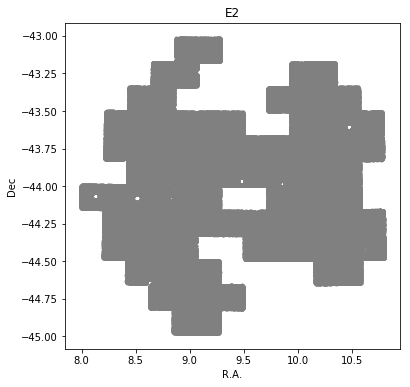

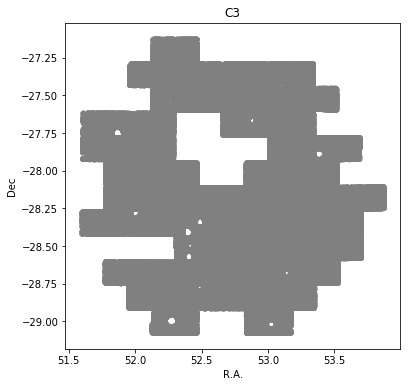

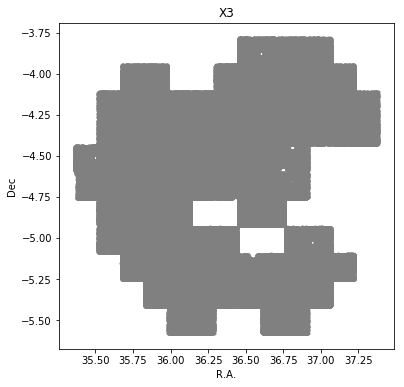

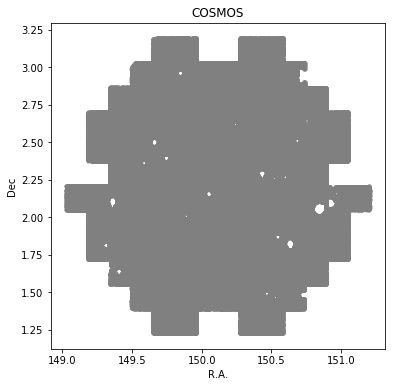

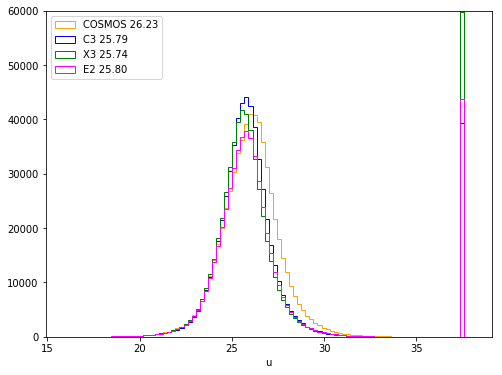

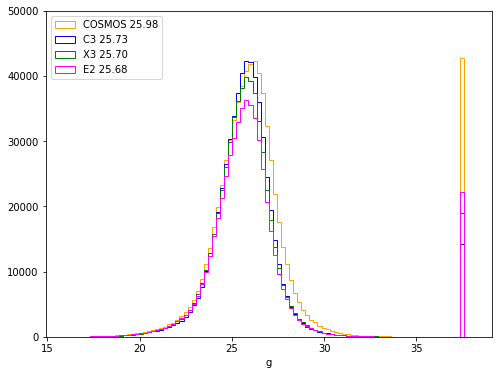

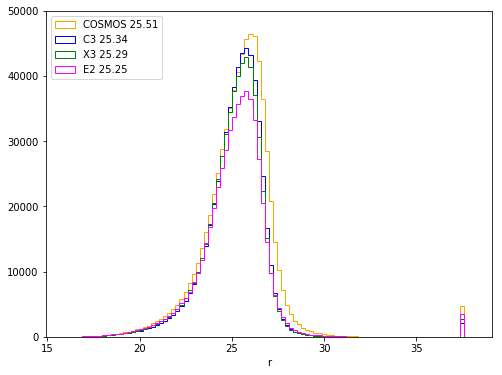

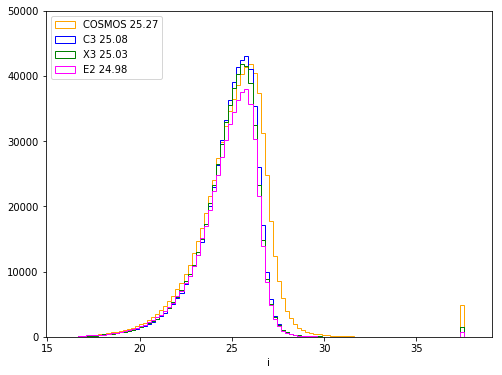

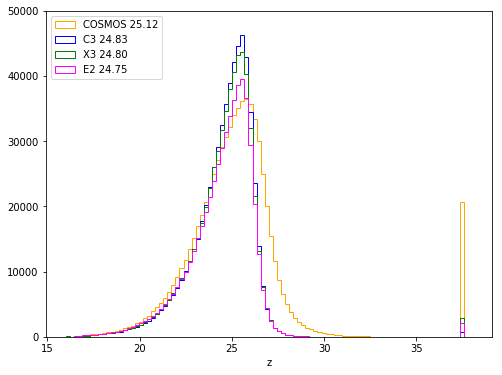

In [2]:
#reading in ext corr instead

deep_fields_files = ['/global/cscratch1/sd/aamon/DEEP/MOFcats/run-ugriz-mof02_extcorr.fits',
                     '/global/cscratch1/sd/aamon/DEEP/MOFcats/run-desmofmask_uvd02_cosmos_collated.fits',]


# read in DES file
#desfile = fits.open(deep_fields_files[0])
#snc=Table(desfile[1].data)

#ugriz
deep = fitsio.read(deep_fields_files[0])
print(len(deep))
print('raw length deep :', len(deep))
deep=deep[deep['flags']==0]
print('length deep post flags:', len(deep))
deep=deep[deep['mask_flags']==0]
print('length deep post mask flags:', len(deep))
print(len(deep))

ind = eu.numpy_util.strmatch(deep['tilename'], 'SN-C3*')
#print(ind)
print(len(ind))
c3=deep[ind]
ind = eu.numpy_util.strmatch(deep['tilename'], 'SN-X3*')
x3=deep[ind]
ind = eu.numpy_util.strmatch(deep['tilename'], 'SN-E2*')
e2=deep[ind]
ind = eu.numpy_util.strmatch(deep['tilename'], 'COSMOS*')
cosmos=deep[ind]



print("num deep galaxies post mask_flags=0:",len(x3))

print("num deep galaxies post mask_flags=0:",len(e2))

print("num deep galaxies post mask_flags=0:",len(cosmos))


#print(min(deep['dec']))
#print(min(deep['ra']),max(deep['ra']))

#print("len deep befre position cuts ", len(deep))
#deep=deep[deep['dec']>-45.]
#deep=deep[( deep['ra']>5.) & (deep['ra']<155.)]
#print("len deep after position cuts ", len(deep))

plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(e2['ra'],e2['dec'], marker='.',color='grey')
plt.xlabel('R.A.')
plt.ylabel('Dec')
plt.title('E2')
plt.savefig('DEEPugriz_E2footprint.png', dpi=100)

plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(c3['ra'],c3['dec'], marker='.',color='grey')
plt.xlabel('R.A.')
plt.ylabel('Dec')
plt.title('C3')
plt.savefig('DEEPugriz_C3footprint.png', dpi=100)

plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(x3['ra'],x3['dec'], marker='.',color='grey')
plt.xlabel('R.A.')
plt.ylabel('Dec')
plt.title('X3')
plt.savefig('DEEPugriz_X3footprint.png', dpi=100)

plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(cosmos['ra'],cosmos['dec'], marker='.',color='grey')
plt.xlabel('R.A.')
plt.ylabel('Dec')
plt.title('COSMOS')
plt.savefig('DEEPugriz_Cosmosfootprint.png', dpi=100)

plt.figure()
fig, ax = plt.subplots(figsize=(8,6))
plt.hist(cosmos['bdf_mag_dered'][:,0],100,color='orange',range=(16,38),label='COSMOS %.5s' %  (np.median(cosmos['bdf_mag_dered'][:,0])),histtype='step' )
plt.hist(c3['bdf_mag_dered'][:,0],100,color='blue',range=(16,38),label='C3 %.5s ' %  (np.median(c3['bdf_mag_dered'][:,0])),histtype='step' )
plt.hist(x3['bdf_mag_dered'][:,0],100,color='green',range=(16,38),label='X3 %.5s' %  (np.median(x3['bdf_mag_dered'][:,0])),histtype='step' )
plt.hist(e2['bdf_mag_dered'][:,0],100,color='magenta',range=(16,38),label='E2 %.5s' %  (np.median(e2['bdf_mag_dered'][:,0])),histtype='step' )
plt.ylim((0,60000))
#plt.hist(deep_data[deep_data['FIELD']=='X3']['bdf_mag_dered_J'],100,color='blue',alpha=0.5,label='X3 %s' %len(x3))
plt.xlabel('u')
#plt.yscale('log')
plt.legend(loc='upper left')
plt.savefig('DEEPugriz_u.png', dpi=100)

plt.figure()
fig, ax = plt.subplots(figsize=(8,6))
plt.hist(cosmos['bdf_mag_dered'][:,1],100,color='orange',range=(16,38),label='COSMOS %.5s' %  (np.median(cosmos['bdf_mag_dered'][:,1])),histtype='step')
plt.hist(c3['bdf_mag_dered'][:,1],100,color='blue',range=(16,38),label='C3 %.5s ' %  (np.median(c3['bdf_mag_dered'][:,1])) ,histtype='step')
plt.hist(x3['bdf_mag_dered'][:,1],100,color='green',range=(16,38),label='X3 %.5s' %  (np.median(x3['bdf_mag_dered'][:,1])),histtype='step')
plt.hist(e2['bdf_mag_dered'][:,1],100,color='magenta',range=(16,38),label='E2 %.5s' %  (np.median(e2['bdf_mag_dered'][:,1])),histtype='step')
plt.ylim((0,50000))
#plt.hist(deep_data[deep_data['FIELD']=='X3']['bdf_mag_dered_J'],100,color='blue',alpha=0.5,label='X3 %s' %len(x3))
plt.xlabel('g')
#plt.yscale('log')
plt.legend(loc='upper left')
plt.savefig('DEEPugriz_g.png', dpi=100)

plt.figure()
fig, ax = plt.subplots(figsize=(8,6))
plt.hist(cosmos['bdf_mag_dered'][:,2],100,color='orange',range=(16,38),label='COSMOS %.5s' %  (np.median(cosmos['bdf_mag_dered'][:,2])),histtype='step')
plt.hist(c3['bdf_mag_dered'][:,2],100,color='blue',range=(16,38),label='C3 %.5s ' %  (np.median(c3['bdf_mag_dered'][:,2])),histtype='step')
plt.hist(x3['bdf_mag_dered'][:,2],100,color='green',range=(16,38),label='X3 %.5s' %  (np.median(x3['bdf_mag_dered'][:,2])),histtype='step')
plt.hist(e2['bdf_mag_dered'][:,2],100,color='magenta',range=(16,38),label='E2 %.5s' %  (np.median(e2['bdf_mag_dered'][:,2])),histtype='step')
plt.ylim((0,50000))
#plt.hist(deep_data[deep_data['FIELD']=='X3']['bdf_mag_dered_J'],100,color='blue',alpha=0.5,label='X3 %s' %len(x3))
plt.xlabel('r')
#plt.yscale('log')
plt.legend(loc='upper left')
plt.savefig('DEEPugriz_r.png', dpi=100)

plt.figure()
fig, ax = plt.subplots(figsize=(8,6))
plt.hist(cosmos['bdf_mag_dered'][:,3],100,color='orange',range=(16,38),label='COSMOS %.5s' %  (np.median(cosmos['bdf_mag_dered'][:,3])),histtype='step')
plt.hist(c3['bdf_mag_dered'][:,3],100,color='blue',range=(16,38),label='C3 %.5s ' %  (np.median(c3['bdf_mag_dered'][:,3])),histtype='step')
plt.hist(x3['bdf_mag_dered'][:,3],100,color='green',range=(16,38),label='X3 %.5s' %  (np.median(x3['bdf_mag_dered'][:,3])),histtype='step')
plt.hist(e2['bdf_mag_dered'][:,3],100,color='magenta',range=(16,38),label='E2 %.5s' %  (np.median(e2['bdf_mag_dered'][:,3])),histtype='step')
plt.ylim((0,50000))
#plt.hist(deep_data[deep_data['FIELD']=='X3']['bdf_mag_dered_J'],100,color='blue',alpha=0.5,label='X3 %s' %len(x3))
plt.xlabel('i')
#plt.yscale('log')
plt.legend(loc='upper left')
plt.savefig('DEEPugriz_i.png', dpi=100)

plt.figure()
fig, ax = plt.subplots(figsize=(8,6))
plt.hist(cosmos['bdf_mag_dered'][:,4],100,color='orange',range=(16,38),label='COSMOS %.5s' %  (np.median(cosmos['bdf_mag_dered'][:,4])),histtype='step')
plt.hist(c3['bdf_mag_dered'][:,4],100,color='blue',range=(16,38),label='C3 %.5s ' %  (np.median(c3['bdf_mag_dered'][:,4])),histtype='step')
plt.hist(x3['bdf_mag_dered'][:,4],100,color='green',range=(16,38),label='X3 %.5s' %  (np.median(x3['bdf_mag_dered'][:,4])),histtype='step')
plt.hist(e2['bdf_mag_dered'][:,4],100,color='magenta',range=(16,38),label='E2 %.5s' %  (np.median(e2['bdf_mag_dered'][:,4])),histtype='step')
plt.ylim((0,50000))
#plt.hist(deep_data[deep_data['FIELD']=='X3']['bdf_mag_dered_J'],100,color='blue',alpha=0.5,label='X3 %s' %len(x3))
plt.xlabel('z')
#plt.yscale('log')
plt.legend(loc='upper left')
plt.savefig('DEEPugriz_z.png', dpi=100)

#print(deep['bdf_mag_dered'][:,2]) #u gri z YJHKs
#print(len(deep['mag_auto']))

#ASSUMING MAGS ARE UGRI Z YJHKS
deepra=deep['ra']
deepdec=deep['dec']


#for ugriz dered
deepg=deep['bdf_mag_dered'][:,1]
deepr=deep['bdf_mag_dered'][:,2]
deepi=deep['bdf_mag_dered'][:,3]
deepz=deep['bdf_mag_dered'][:,4]

print(min(deepdec))
print(max(deepra))

In [ ]:
plt.figure()
fig, axarr = plt.subplots(4,4, figsize=(12.,16.) )


axarr[0,0].hist2d(c3['bdf_mag_dered'][:,3],c3['bdf_mag_dered'][:,2]-c3['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5), vmin=0, vmax=250)#, marker='.',s=4,color='black',alpha=0.1)
axarr[0,0].set_ylim(-2,2)
axarr[0,0].set_xlim(15,25)
axarr[0,0].set_title('C3')
axarr[0,0].set_ylabel('bdf_mag_dered r-i')
axarr[0,0].set_xlabel('bdf_mag_dered i')

axarr[0,1].hist2d(x3['bdf_mag_dered'][:,3],x3['bdf_mag_dered'][:,2]-x3['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5), vmin=0, vmax=250)#, marker='.',s=4,color='black',alpha=0.1)
axarr[0,1].set_ylim(-2,2)
axarr[0,1].set_xlim(15,25)
axarr[0,1].set_title('X3')
#axarr[0,1].set_ylabel('bdf_mag_dered r-i')
axarr[0,1].set_xlabel('bdf_mag_dered i')


im = axarr[0,2].hist2d(e2['bdf_mag_dered'][:,3],e2['bdf_mag_dered'][:,2]-e2['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5), vmin=0, vmax=250)#, marker='.',s=4,color='black',alpha=0.1)
axarr[0,2].set_ylim(-2,2)
axarr[0,2].set_xlim(15,25)
axarr[0,2].set_title('E2')
#axarr[0,2].set_ylabel('bdf_mag_dered_dered r-i')
axarr[0,2].set_xlabel('bdf_mag_dered i')

im = axarr[0,3].hist2d(cosmos['bdf_mag_dered'][:,3],cosmos['bdf_mag_dered'][:,2]-cosmos['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5), vmin=0, vmax=250)#, marker='.',s=4,color='black',alpha=0.1)
axarr[0,3].set_ylim(-2,2)
axarr[0,3].set_xlim(15,25)
axarr[0,3].set_title('COSMOS')
#axarr[0,3].set_ylabel('bdf_mag_dered r-i')
axarr[0,3].set_xlabel('bdf_mag_dered i')


#axarr[0,3].axis('off')
divider = make_axes_locatable(axarr[0,3])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im[3],ax=axarr[0,3],cax=cax)

#####################
im = axarr[1,0].hist2d(c3['bdf_mag_dered'][:,3],c3['bdf_mag_dered'][:,4]-c3['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5), vmin=0, vmax=250)#, marker='.',s=4,color='black',alpha=0.1)
axarr[1,0].set_ylim(-2,2)
axarr[1,0].set_xlim(15,25)
axarr[1,0].set_title('C3')
axarr[1,0].set_ylabel('bdf_mag_dered z-i')
axarr[1,0].set_xlabel('bdf_mag_dered i')

im = axarr[1,1].hist2d(x3['bdf_mag_dered'][:,3],x3['bdf_mag_dered'][:,4]-x3['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5), vmin=0, vmax=250)#, marker='.',s=4,color='black',alpha=0.1)
axarr[1,1].set_ylim(-2,2)
axarr[1,1].set_xlim(15,25)
axarr[1,1].set_title('X3')
#axarr[1,1].set_ylabel('bdf_mag_dered z-i')
axarr[1,1].set_xlabel('bdf_mag_dered i')


im = axarr[1,2].hist2d(e2['bdf_mag_dered'][:,3],e2['bdf_mag_dered'][:,4]-e2['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5), vmin=0, vmax=250)#, marker='.',s=4,color='black',alpha=0.1)
axarr[1,2].set_ylim(-2,2)
axarr[1,2].set_xlim(15,25)
axarr[1,2].set_title('E2')
#axarr[1,2].set_ylabel('bdf_mag_dered z-i')
axarr[1,2].set_xlabel('bdf_mag_dered i')

im = axarr[1,3].hist2d(cosmos['bdf_mag_dered'][:,3],cosmos['bdf_mag_dered'][:,4]-cosmos['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5), vmin=0, vmax=250)#, marker='.',s=4,color='black',alpha=0.1)
axarr[1,3].set_ylim(-2,2)
axarr[1,3].set_xlim(15,25)
axarr[1,3].set_title('COSMOS')
#axarr[0,3].set_ylabel('bdf_mag_dered r-i')
axarr[1,3].set_xlabel('bdf_mag_dered i')


#axarr[1,3].axis('off')
#divider = make_axes_locatable(axarr[1,3])
#cax = divider.append_axes("right", size="5%", pad=0.05)
#fig.colorbar(im[3],ax=axarr[1,3],cax=cax)

#axarr[1].set_title('Laigle et al. COSMOS Data')
#plt.savefig(outdir + 'ri_i_hexbin.png', dpi=100)

divider = make_axes_locatable(axarr[1,3])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im[3],ax=axarr[1,3],cax=cax)

#####################


#plt.figure()
#fig, axarr = plt.subplots(1,3, figsize=(10.,9.))
"""
axarr[2,0].hist2d(c3['bdf_mag_dered'][:,1]-c3['bdf_mag_dered'][:,2],c3['bdf_mag_dered'][:,2]-c3['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=6,color='k',alpha=0.1)#,gridsize=50)
axarr[2,0].set_ylim(-5,5)
axarr[2,0].set_xlim(-5,5)
axarr[2,0].set_title('C3')
axarr[2,0].set_ylabel('bdf_mag_dered r-i')
axarr[2,0].set_xlabel('bdf_mag_dered g-r')

axarr[2,1].hist2d(x3['bdf_mag_dered'][:,1]-x3['bdf_mag_dered'][:,2],x3['bdf_mag_dered'][:,2]-x3['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=6,color='black',alpha=0.1)
axarr[2,1].set_ylim(-5,5)
axarr[2,1].set_xlim(-5,5)
axarr[2,1].set_title('X3')
#axarr[2,1].set_ylabel('bdf_mag_dered r-i')
axarr[2,1].set_xlabel('bdf_mag_dered g-r')


axarr[2,2].hist2d(e2['bdf_mag_dered'][:,0]-e2['bdf_mag_dered'][:,1],e2['bdf_mag_dered'][:,1]-e2['bdf_mag_dered'][:,2], bins=1000, norm=mcolors.PowerNorm(0.5)) #, marker='.',s=6,color='black',alpha=0.1)
axarr[2,2].set_ylim(-5,5)
axarr[2,2].set_xlim(-5,5)
axarr[2,2].set_title('E2')
#axarr[2,2].set_ylabel('bdf_mag_dered r-i')
axarr[2,2].set_xlabel('bdf_mag_dered g-r')
"""
axarr[2,0].scatter(c3['bdf_mag_dered'][:,1]-c3['bdf_mag_dered'][:,2],c3['bdf_mag_dered'][:,2]-c3['bdf_mag_dered'][:,3], marker='.',s=6,color='k',alpha=0.01)#,gridsize=50)
axarr[2,0].set_ylim(-25,25)
axarr[2,0].set_xlim(-25,25)
axarr[2,0].set_title('C3')
axarr[2,0].set_ylabel('bdf_mag_dered r-i')
axarr[2,0].set_xlabel('bdf_mag_dered g-r')

axarr[2,1].scatter(x3['bdf_mag_dered'][:,1]-x3['bdf_mag_dered'][:,2],x3['bdf_mag_dered'][:,2]-x3['bdf_mag_dered'][:,3], marker='.',s=6,color='black',alpha=0.01)
axarr[2,1].set_ylim(-25,25)
axarr[2,1].set_xlim(-25,25)
axarr[2,1].set_title('X3')
axarr[2,1].set_ylabel('bdf_mag_dered r-i')
axarr[2,1].set_xlabel('bdf_mag_dered g-r')


axarr[2,2].scatter(e2['bdf_mag_dered'][:,1]-e2['bdf_mag_dered'][:,2],e2['bdf_mag_dered'][:,2]-e2['bdf_mag_dered'][:,3], marker='.',s=6,color='black',alpha=0.01)
axarr[2,2].set_ylim(-25,25)
axarr[2,2].set_xlim(-25,25)
axarr[2,2].set_title('E2')
axarr[2,2].set_ylabel('bdf_mag_dered r-i')
axarr[2,2].set_xlabel('bdf_mag_dered g-r')

axarr[2,3].scatter(cosmos['bdf_mag_dered'][:,1]-cosmos['bdf_mag_dered'][:,2],cosmos['bdf_mag_dered'][:,2]-cosmos['bdf_mag_dered'][:,3], marker='.',s=6,color='black',alpha=0.01)
#axarr[2].set_ylim(-5,20)
axarr[2,3].set_ylim(-25,25)
axarr[2,3].set_xlim(-25,25)
axarr[2,3].set_title('COSMOS')
axarr[2,3].set_ylabel('bdf_mag_dered r-i')
axarr[2,3].set_xlabel('bdf_mag_dered g-r')





######################


axarr[3,0].hist2d(c3['bdf_mag_dered'][:,1]-c3['bdf_mag_dered'][:,2],c3['bdf_mag_dered'][:,2]-c3['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5), vmin=0, vmax=1000)#, marker='.',s=4,color='black',alpha=0.1)
axarr[3,0].set_ylim(-0.5,2)
axarr[3,0].set_xlim(-0.5,2)
axarr[3,0].set_title('C3')
axarr[3,0].set_ylabel('bdf_mag_dered r-i')
axarr[3,0].set_xlabel('bdf_mag_dered g-r')

axarr[3,1].hist2d(x3['bdf_mag_dered'][:,1]-x3['bdf_mag_dered'][:,2],x3['bdf_mag_dered'][:,2]-x3['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5), vmin=0, vmax=1000)#, marker='.',s=4,color='black',alpha=0.1)
axarr[3,1].set_ylim(-0.5,2)
axarr[3,1].set_xlim(-0.5,2)
axarr[3,1].set_title('X3')
#axarr[1].set_ylabel('bdf_mag_dered r-i')
axarr[3,1].set_xlabel('bdf_mag_dered g-r')


h=axarr[3,2].hist2d(e2['bdf_mag_dered'][:,1]-e2['bdf_mag_dered'][:,2],e2['bdf_mag_dered'][:,2]-e2['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5), vmin=0, vmax=1000)#, marker='.',s=4,color='black',alpha=0.1)
axarr[3,2].set_ylim(-0.5,2)
axarr[3,2].set_xlim(-0.5,2)
axarr[3,2].set_title('E2')
#axarr[2].set_ylabel('bdf_mag_dered r-i')
axarr[3,2].set_xlabel('bdf_mag_dered g-r')

im=axarr[3,3].hist2d(cosmos['bdf_mag_dered'][:,1]-cosmos['bdf_mag_dered'][:,2],cosmos['bdf_mag_dered'][:,2]-cosmos['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5), vmin=0, vmax=1000)#, marker='.',s=4,color='black',alpha=0.1)
axarr[3,3].set_ylim(-0.5,2)
axarr[3,3].set_xlim(-0.5,2)
axarr[3,3].set_title('E2')
#axarr[2].set_ylabel('bdf_mag_dered r-i')
axarr[3,3].set_xlabel('bdf_mag_dered g-r') 

#cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
#fig.colorbar(im, cax=cax)

#cb = plt.colorbar()


#axarr[3,3].axis('off')
divider = make_axes_locatable(axarr[3,3])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im[3],ax=axarr[3,3],cax=cax)



#plt.subplots_adjust(left=1/16.0, right=1-1/16.0, bottom=1/8.0, top=1-1/8.0)
#forceAspect(axarr,aspect=1)
#plt.colorbar(h, ax=axarr)
fig.tight_layout()
plt.savefig("Deepconsistency_bdfmag_dered")
plt.show()

In [ ]:
#only look at faint galaxies 

maglim=22
c3=c3[c3['bdf_mag_dered'][:,3]>maglim]
print(len(c3))
x3=x3[x3['bdf_mag_dered'][:,3]>maglim]
e2=e2[e2['bdf_mag_dered'][:,3]>maglim]
cosmos=cosmos[cosmos['bdf_mag_dered'][:,3]>maglim]

In [ ]:
plt.figure()
fig, axarr = plt.subplots(4,4, figsize=(12.,16.) )


axarr[0,0].hist2d(c3['bdf_mag_dered'][:,3],c3['bdf_mag_dered'][:,2]-c3['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5), vmin=0, vmax=250)#, marker='.',s=4,color='black',alpha=0.1)
axarr[0,0].set_ylim(-2,2)
axarr[0,0].set_xlim(maglim,30)
axarr[0,0].set_title('C3')
axarr[0,0].set_ylabel('bdf_mag_dered r-i')
axarr[0,0].set_xlabel('bdf_mag_dered i')

divider = make_axes_locatable(axarr[0,3])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im[3],ax=axarr[0,3],cax=cax)

axarr[0,1].hist2d(x3['bdf_mag_dered'][:,3],x3['bdf_mag_dered'][:,2]-x3['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5), vmin=0, vmax=250)#, marker='.',s=4,color='black',alpha=0.1)
axarr[0,1].set_ylim(-2,2)
axarr[0,1].set_xlim(maglim,30)
axarr[0,1].set_title('X3')
#axarr[0,1].set_ylabel('bdf_mag_dered r-i')
axarr[0,1].set_xlabel('bdf_mag_dered i')


im = axarr[0,2].hist2d(e2['bdf_mag_dered'][:,3],e2['bdf_mag_dered'][:,2]-e2['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5), vmin=0, vmax=250)#, marker='.',s=4,color='black',alpha=0.1)
axarr[0,2].set_ylim(-2,2)
axarr[0,2].set_xlim(maglim,30)
axarr[0,2].set_title('E2')
#axarr[0,2].set_ylabel('bdf_mag_dered_dered r-i')
axarr[0,2].set_xlabel('bdf_mag_dered i')


im = axarr[0,3].hist2d(cosmos['bdf_mag_dered'][:,3],cosmos['bdf_mag_dered'][:,2]-cosmos['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5), vmin=0, vmax=250)#, marker='.',s=4,color='black',alpha=0.1)
axarr[0,3].set_ylim(-2,2)
axarr[0,3].set_xlim(maglim,30)
axarr[0,3].set_title('COSMOS')
#axarr[0,3].set_ylabel('bdf_mag_dered r-i')
axarr[0,3].set_xlabel('bdf_mag_dered i')


#axarr[0,3].axis('off')
divider = make_axes_locatable(axarr[0,3])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im[3],ax=axarr[0,3],cax=cax)

#####################
im = axarr[1,0].hist2d(c3['bdf_mag_dered'][:,3],c3['bdf_mag_dered'][:,4]-c3['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5), vmin=0, vmax=250)#, marker='.',s=4,color='black',alpha=0.1)
axarr[1,0].set_ylim(-2,2)
axarr[1,0].set_xlim(maglim,30)
axarr[1,0].set_title('C3')
axarr[1,0].set_ylabel('bdf_mag_dered z-i')
axarr[1,0].set_xlabel('bdf_mag_dered i')

im = axarr[1,1].hist2d(x3['bdf_mag_dered'][:,3],x3['bdf_mag_dered'][:,4]-x3['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5), vmin=0, vmax=250)#, marker='.',s=4,color='black',alpha=0.1)
axarr[1,1].set_ylim(-2,2)
axarr[1,1].set_xlim(maglim,30)
axarr[1,1].set_title('X3')
#axarr[1,1].set_ylabel('bdf_mag_dered z-i')
axarr[1,1].set_xlabel('bdf_mag_dered i')


im = axarr[1,2].hist2d(e2['bdf_mag_dered'][:,3],e2['bdf_mag_dered'][:,4]-e2['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5), vmin=0, vmax=250)#, marker='.',s=4,color='black',alpha=0.1)
axarr[1,2].set_ylim(-2,2)
axarr[1,2].set_xlim(maglim,30)
axarr[1,2].set_title('E2')
#axarr[1,2].set_ylabel('bdf_mag_dered z-i')
axarr[1,2].set_xlabel('bdf_mag_dered i')

im = axarr[1,3].hist2d(cosmos['bdf_mag_dered'][:,3],cosmos['bdf_mag_dered'][:,4]-cosmos['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5), vmin=0, vmax=250)#, marker='.',s=4,color='black',alpha=0.1)
axarr[1,3].set_ylim(-2,2)
axarr[1,3].set_xlim(maglim,30)
axarr[1,3].set_title('COSMOS')
#axarr[0,3].set_ylabel('bdf_mag_dered r-i')
axarr[1,3].set_xlabel('bdf_mag_dered i')


#axarr[1,3].axis('off')
divider = make_axes_locatable(axarr[1,3])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im[3],ax=axarr[1,3],cax=cax)

#axarr[1].set_title('Laigle et al. COSMOS Data')
#plt.savefig(outdir + 'ri_i_hexbin.png', dpi=100)

#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=cbar_ax)

#####################


#plt.figure()
#fig, axarr = plt.subplots(1,3, figsize=(10.,9.))
"""
axarr[2,0].hist2d(c3['bdf_mag_dered'][:,1]-c3['bdf_mag_dered'][:,2],c3['bdf_mag_dered'][:,2]-c3['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=6,color='k',alpha=0.1)#,gridsize=50)
axarr[2,0].set_ylim(-5,5)
axarr[2,0].set_xlim(-5,5)
axarr[2,0].set_title('C3')
axarr[2,0].set_ylabel('bdf_mag_dered r-i')
axarr[2,0].set_xlabel('bdf_mag_dered g-r')

axarr[2,1].hist2d(x3['bdf_mag_dered'][:,1]-x3['bdf_mag_dered'][:,2],x3['bdf_mag_dered'][:,2]-x3['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=6,color='black',alpha=0.1)
axarr[2,1].set_ylim(-5,5)
axarr[2,1].set_xlim(-5,5)
axarr[2,1].set_title('X3')
#axarr[2,1].set_ylabel('bdf_mag_dered r-i')
axarr[2,1].set_xlabel('bdf_mag_dered g-r')


axarr[2,2].hist2d(e2['bdf_mag_dered'][:,0]-e2['bdf_mag_dered'][:,1],e2['bdf_mag_dered'][:,1]-e2['bdf_mag_dered'][:,2], bins=1000, norm=mcolors.PowerNorm(0.5)) #, marker='.',s=6,color='black',alpha=0.1)
axarr[2,2].set_ylim(-5,5)
axarr[2,2].set_xlim(-5,5)
axarr[2,2].set_title('E2')
#axarr[2,2].set_ylabel('bdf_mag_dered r-i')
axarr[2,2].set_xlabel('bdf_mag_dered g-r')
"""
axarr[2,0].scatter(c3['bdf_mag_dered'][:,1]-c3['bdf_mag_dered'][:,2],c3['bdf_mag_dered'][:,2]-c3['bdf_mag_dered'][:,3], marker='.',s=6,color='k',alpha=0.01)#,gridsize=50)
axarr[2,0].set_ylim(-25,25)
axarr[2,0].set_xlim(-25,25)
axarr[2,0].set_title('C3')
axarr[2,0].set_ylabel('bdf_mag_dered r-i')
axarr[2,0].set_xlabel('bdf_mag_dered g-r')

axarr[2,1].scatter(x3['bdf_mag_dered'][:,1]-x3['bdf_mag_dered'][:,2],x3['bdf_mag_dered'][:,2]-x3['bdf_mag_dered'][:,3], marker='.',s=6,color='black',alpha=0.01)
axarr[2,1].set_ylim(-25,25)
axarr[2,1].set_xlim(-25,25)
axarr[2,1].set_title('X3')
axarr[2,1].set_ylabel('bdf_mag_dered r-i')
axarr[2,1].set_xlabel('bdf_mag_dered g-r')


axarr[2,2].scatter(e2['bdf_mag_dered'][:,1]-e2['bdf_mag_dered'][:,2],e2['bdf_mag_dered'][:,2]-e2['bdf_mag_dered'][:,3], marker='.',s=6,color='black',alpha=0.01)
axarr[2,2].set_ylim(-25,25)
axarr[2,2].set_xlim(-25,25)
axarr[2,2].set_title('E2')
axarr[2,2].set_ylabel('bdf_mag_dered r-i')
axarr[2,2].set_xlabel('bdf_mag_dered g-r')

axarr[2,3].scatter(cosmos['bdf_mag_dered'][:,1]-cosmos['bdf_mag_dered'][:,2],cosmos['bdf_mag_dered'][:,2]-cosmos['bdf_mag_dered'][:,3], marker='.',s=6,color='black',alpha=0.01)
#axarr[2].set_ylim(-5,20)
axarr[2,3].set_ylim(-25,25)
axarr[2,3].set_xlim(-25,25)
axarr[2,3].set_title('COSMOS')
axarr[2,3].set_ylabel('bdf_mag_dered r-i')
axarr[2,3].set_xlabel('bdf_mag_dered g-r')



#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=cbar_ax)

######################


axarr[3,0].hist2d(c3['bdf_mag_dered'][:,1]-c3['bdf_mag_dered'][:,2],c3['bdf_mag_dered'][:,2]-c3['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5), vmin=0, vmax=1000)#, marker='.',s=4,color='black',alpha=0.1)
axarr[3,0].set_ylim(-0.5,2)
axarr[3,0].set_xlim(-0.5,2)
axarr[3,0].set_title('C3')
axarr[3,0].set_ylabel('bdf_mag_dered r-i')
axarr[3,0].set_xlabel('bdf_mag_dered g-r')

axarr[3,1].hist2d(x3['bdf_mag_dered'][:,1]-x3['bdf_mag_dered'][:,2],x3['bdf_mag_dered'][:,2]-x3['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5), vmin=0, vmax=1000)#, marker='.',s=4,color='black',alpha=0.1)
axarr[3,1].set_ylim(-0.5,2)
axarr[3,1].set_xlim(-0.5,2)
axarr[3,1].set_title('X3')
#axarr[1].set_ylabel('bdf_mag_dered r-i')
axarr[3,1].set_xlabel('bdf_mag_dered g-r')


h=axarr[3,2].hist2d(e2['bdf_mag_dered'][:,1]-e2['bdf_mag_dered'][:,2],e2['bdf_mag_dered'][:,2]-e2['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5), vmin=0, vmax=1000)#, marker='.',s=4,color='black',alpha=0.1)
axarr[3,2].set_ylim(-0.5,2)
axarr[3,2].set_xlim(-0.5,2)
axarr[3,2].set_title('E2')
#axarr[2].set_ylabel('bdf_mag_dered r-i')
axarr[3,2].set_xlabel('bdf_mag_dered g-r')

im=axarr[3,3].hist2d(cosmos['bdf_mag_dered'][:,1]-cosmos['bdf_mag_dered'][:,2],cosmos['bdf_mag_dered'][:,2]-cosmos['bdf_mag_dered'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5), vmin=0, vmax=1000)#, marker='.',s=4,color='black',alpha=0.1)
axarr[3,3].set_ylim(-0.5,2)
axarr[3,3].set_xlim(-0.5,2)
axarr[3,3].set_title('E2')
#axarr[2].set_ylabel('bdf_mag_dered r-i')
axarr[3,3].set_xlabel('bdf_mag_dered g-r') 

#cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
#fig.colorbar(im, cax=cax)

#cb = plt.colorbar()


#axarr[3,3].axis('off')
divider = make_axes_locatable(axarr[3,3])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im[3],ax=axarr[3,3],cax=cax)


#plt.subplots_adjust(left=1/16.0, right=1-1/16.0, bottom=1/8.0, top=1-1/8.0)
#forceAspect(axarr,aspect=1)
#plt.colorbar(h, ax=axarr)
fig.tight_layout()
plt.savefig("Deepconsistency_bdfmag_dered_faint22")
plt.show()

In [ ]:
plt.figure()
fig, axarr = plt.subplots(4,4, figsize=(12.,16.) )


axarr[0,0].hist2d(c3['psf_mag'][:,3],c3['psf_mag'][:,2]-c3['psf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[0,0].set_ylim(-2,2)
axarr[0,0].set_xlim(15,25)
axarr[0,0].set_title('C3')
axarr[0,0].set_ylabel('psf_MAG r-i')
axarr[0,0].set_xlabel('psf_MAG i')

axarr[0,1].hist2d(x3['psf_mag'][:,3],x3['psf_mag'][:,2]-x3['psf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[0,1].set_ylim(-2,2)
axarr[0,1].set_xlim(15,25)
axarr[0,1].set_title('X3')
#axarr[0,1].set_ylabel('psf_MAG r-i')
axarr[0,1].set_xlabel('psf_MAG i')


im = axarr[0,2].hist2d(e2['psf_mag'][:,2],e2['psf_mag'][:,1]-e2['psf_mag'][:,2], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[0,2].set_ylim(-2,2)
axarr[0,2].set_xlim(15,25)
axarr[0,2].set_title('E2')
#axarr[0,2].set_ylabel('psf_MAG r-i')
axarr[0,2].set_xlabel('psf_MAG i')

im = axarr[0,3].hist2d(cosmos['psf_mag'][:,3],cosmos['psf_mag'][:,1]-cosmos['psf_mag'][:,2], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[0,3].set_ylim(-2,2)
axarr[0,3].set_xlim(15,25)
axarr[0,3].set_title('COSMOS')
#axarr[0,3].set_ylabel('psf_MAG r-i')
axarr[0,3].set_xlabel('psf_MAG i')


axarr[0,3].axis('off')
divider = make_axes_locatable(axarr[0,3])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im[3],ax=axarr[0,3],cax=cax)

#####################
im = axarr[1,0].hist2d(c3['psf_mag'][:,3],c3['psf_mag'][:,4]-c3['psf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[1,0].set_ylim(-2,2)
axarr[1,0].set_xlim(15,25)
axarr[1,0].set_title('C3')
axarr[1,0].set_ylabel('psf_MAG z-i')
axarr[1,0].set_xlabel('psf_MAG i')

im = axarr[1,1].hist2d(x3['psf_mag'][:,3],x3['psf_mag'][:,4]-x3['psf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[1,1].set_ylim(-2,2)
axarr[1,1].set_xlim(15,25)
axarr[1,1].set_title('X3')
#axarr[1,1].set_ylabel('psf_MAG z-i')
axarr[1,1].set_xlabel('psf_MAG i')


im = axarr[1,2].hist2d(e2['psf_mag'][:,2],e2['psf_mag'][:,3]-e2['psf_mag'][:,2], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[1,2].set_ylim(-2,2)
axarr[1,2].set_xlim(15,25)
axarr[1,2].set_title('E2')
#axarr[1,2].set_ylabel('psf_MAG z-i')
axarr[1,2].set_xlabel('psf_MAG i')

im = axarr[1,3].hist2d(cosmos['psf_mag'][:,3],cosmos['psf_mag'][:,4]-cosmos['psf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[1,3].set_ylim(-2,2)
axarr[1,3].set_xlim(15,25)
axarr[1,3].set_title('COSMOS')
#axarr[0,3].set_ylabel('psf_MAG r-i')
axarr[1,3].set_xlabel('psf_MAG i')


axarr[1,3].axis('off')
divider = make_axes_locatable(axarr[1,3])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im[3],ax=axarr[1,3],cax=cax)

#axarr[1].set_title('Laigle et al. COSMOS Data')
#plt.savefig(outdir + 'ri_i_hexbin.png', dpi=100)

#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=cbar_ax)

#####################


#plt.figure()
#fig, axarr = plt.subplots(1,3, figsize=(10.,9.))

axarr[2,0].scatter(c3['psf_mag'][:,1]-c3['psf_mag'][:,2],c3['psf_mag'][:,2]-c3['psf_mag'][:,3], marker='.',s=6,color='k',alpha=0.01)#,gridsize=50)
axarr[2,0].set_ylim(-25,25)
axarr[2,0].set_xlim(-25,25)
axarr[2,0].set_title('C3')
axarr[2,0].set_ylabel('psf_MAG r-i')
axarr[2,0].set_xlabel('psf_MAG g-r')

axarr[2,1].scatter(x3['psf_mag'][:,1]-x3['psf_mag'][:,2],x3['psf_mag'][:,2]-x3['psf_mag'][:,3], marker='.',s=6,color='black',alpha=0.01)
axarr[2,1].set_ylim(-25,25)
axarr[2,1].set_xlim(-25,25)
axarr[2,1].set_title('X3')
axarr[2,1].set_ylabel('psf_MAG r-i')
axarr[2,1].set_xlabel('psf_MAG g-r')


axarr[2,2].scatter(e2['psf_mag'][:,0]-e2['psf_mag'][:,1],e2['psf_mag'][:,1]-e2['psf_mag'][:,2], marker='.',s=6,color='black',alpha=0.01)
axarr[2,2].set_ylim(-25,25)
axarr[2,2].set_xlim(-25,25)
axarr[2,2].set_title('E2')
axarr[2,2].set_ylabel('psf_MAG r-i')
axarr[2,2].set_xlabel('psf_MAG g-r')

axarr[2,3].scatter(cosmos['psf_mag'][:,1]-cosmos['psf_mag'][:,2],cosmos['psf_mag'][:,2]-cosmos['psf_mag'][:,3], marker='.',s=6,color='black',alpha=0.01)
#axarr[2].set_ylim(-5,20)
axarr[2,3].set_ylim(-25,25)
axarr[2,3].set_xlim(-25,25)
axarr[2,3].set_title('COSMOS')
axarr[2,3].set_ylabel('psf_MAG r-i')
axarr[2,3].set_xlabel('psf_MAG i')



#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=cbar_ax)

######################


axarr[3,0].hist2d(c3['psf_mag'][:,1]-c3['psf_mag'][:,2],c3['psf_mag'][:,2]-c3['psf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[3,0].set_ylim(-0.5,2)
axarr[3,0].set_xlim(-0.5,2)
axarr[3,0].set_title('C3')
axarr[3,0].set_ylabel('psf_MAG r-i')
axarr[3,0].set_xlabel('psf_MAG g-r')

axarr[3,1].hist2d(x3['psf_mag'][:,1]-x3['psf_mag'][:,2],x3['psf_mag'][:,2]-x3['psf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[3,1].set_ylim(-0.5,2)
axarr[3,1].set_xlim(-0.5,2)
axarr[3,1].set_title('X3')
#axarr[1].set_ylabel('psf_MAG r-i')
axarr[3,1].set_xlabel('psf_MAG g-r')


h=axarr[3,2].hist2d(e2['psf_mag'][:,0]-e2['psf_mag'][:,1],e2['psf_mag'][:,1]-e2['psf_mag'][:,2], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[3,2].set_ylim(-0.5,2)
axarr[3,2].set_xlim(-0.5,2)
axarr[3,2].set_title('E2')
#axarr[2].set_ylabel('psf_MAG r-i')
axarr[3,2].set_xlabel('psf_MAG g-r')

im=axarr[3,3].hist2d(cosmos['psf_mag'][:,1]-cosmos['psf_mag'][:,2],cosmos['psf_mag'][:,2]-cosmos['psf_mag'][:,3], bins=1000, norm=mcolors.PowerNorm(0.5))#, marker='.',s=4,color='black',alpha=0.1)
axarr[3,3].set_ylim(-0.5,2)
axarr[3,3].set_xlim(-0.5,2)
axarr[3,3].set_title('E2')
#axarr[2].set_ylabel('psf_MAG r-i')
axarr[3,3].set_xlabel('psf_MAG g-r') 

#cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
#fig.colorbar(im, cax=cax)

#cb = plt.colorbar()


axarr[3,3].axis('off')
divider = make_axes_locatable(axarr[3,3])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im[3],ax=axarr[3,3],cax=cax)



#plt.subplots_adjust(left=1/16.0, right=1-1/16.0, bottom=1/8.0, top=1-1/8.0)
#forceAspect(axarr,aspect=1)
#plt.colorbar(h, ax=axarr)
fig.tight_layout()
plt.savefig("Deepconsistency_psfmag_faint25")
plt.show()

#### 

In [3]:
#READ IN GOLD
import h5py as h5
#catname = '/global/cscratch1/sd/troxel/cats_des_y3/Y3_mastercat_v2_6_20_18.h5'
catname='/project/projectdirs/des/www/y3_cats/Y3_mastercat_7_24_19.h5'

f = h5.File(catname,'r')
print(f['catalog'].keys())
print(f['catalog/gold'].keys())
print(f['catalog/gold/coadd_object_id'])


ra = np.array(f['catalog/gold/ra'])#[star_mask] 
dec = np.array(f['catalog/gold/dec'])#[star_mask]
gflag = np.array(f['catalog/gold/flags_gold'])
badflag =  np.array(f['catalog/gold/flags_badregions'])
print(len(ra))

zeropt=30
g = zeropt- 2.5*np.log10(np.array(f['catalog/gold/sof_cm_flux_corrected_g']))#[star_mask]
r = zeropt- 2.5*np.log10(np.array(f['catalog/gold/sof_cm_flux_corrected_r']))#[star_mask]
i = zeropt- 2.5*np.log10(np.array(f['catalog/gold/sof_cm_flux_corrected_i']))#[star_mask]
z = zeropt- 2.5*np.log10(np.array(f['catalog/gold/sof_cm_flux_corrected_z']))#[star_mask]

#plt.scatter(i , i-np.array(f['catalog/gold/sof_cm_mag_corrected_i']))
#plt.xlabel('i mag from flux')
#plt.xlabel('i mag from flux - i mag')

g = np.array(f['catalog/gold/sof_cm_mag_corrected_g'])#[star_mask]
r = np.array(f['catalog/gold/sof_cm_mag_corrected_r'])#[star_mask]
i = np.array(f['catalog/gold/sof_cm_mag_corrected_i'])#[star_mask]
z = np.array(f['catalog/gold/sof_cm_mag_corrected_z'])#[star_mask]

ra[ra > 180] -= 360

#cutting out only galaxies
#If you are using MOF quantities, (FLAGS_GOLD & 1111001) = 0; and (FLAGS_BADREGIONS & 10) = 0
ra=ra[np.where((gflag==0) | (gflag==2) | (gflag==4) | (gflag==6))]
dec=dec[np.where((gflag==0) | (gflag==2) | (gflag==4) | (gflag==6))]
g=g[np.where((gflag==0) | (gflag==2) | (gflag==4) | (gflag==6))]
r=r[np.where((gflag==0) | (gflag==2) | (gflag==4) | (gflag==6))]
i=i[np.where((gflag==0) | (gflag==2) | (gflag==4) | (gflag==6))]
z=z[np.where((gflag==0) | (gflag==2) | (gflag==4) | (gflag==6))]

gold=np.column_stack((ra,dec,g,r,i,z))
print(len(gold))
print(min(gold[:,0]),max(gold[:,0]),min(gold[:,1]),max(gold[:,1]))


[u'metacal', u'gold', u'bpz', u'dnf', u'redmagic', u'redmapper', u'maglim']
[u'a_sed_sfd98_g', u'a_sed_sfd98_i', u'a_sed_sfd98_r', u'a_sed_sfd98_z', u'coadd_object_id', u'dec', u'delta_mag_chrom_g', u'delta_mag_chrom_i', u'delta_mag_chrom_r', u'delta_mag_chrom_z', u'delta_mag_y4_g', u'delta_mag_y4_i', u'delta_mag_y4_r', u'delta_mag_y4_z', u'ebv_sfd98', u'extended_class_mash_sof', u'flags', u'flags_badregions', u'flags_footprint', u'flags_foreground', u'flags_gold', u'flags_phot', u'hpix_16384', u'n_images_g', u'n_images_i', u'n_images_r', u'n_images_z', u'ra', u'sextractor_flags_g', u'sextractor_flags_i', u'sextractor_flags_r', u'sextractor_flags_z', u'sof_cm_flux_corrected_g', u'sof_cm_flux_corrected_i', u'sof_cm_flux_corrected_r', u'sof_cm_flux_corrected_z', u'sof_cm_flux_err_g', u'sof_cm_flux_err_i', u'sof_cm_flux_err_r', u'sof_cm_flux_err_z', u'sof_cm_mag_corrected_g', u'sof_cm_mag_corrected_i', u'sof_cm_mag_corrected_r', u'sof_cm_mag_corrected_z', u'sof_cm_mag_err_g', u'sof_cm_mag

/global/u2/a/aamon/.conda/envs/DESenv/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/global/u2/a/aamon/.conda/envs/DESenv/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10
/global/u2/a/aamon/.conda/envs/DESenv/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
/global/u2/a/aamon/.conda/envs/DESenv/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log10
/global/u2/a/aamon/.conda/envs/DESenv/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/global/u2/a/aamon/.conda/envs/DESenv/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log10
/global/u2/a/aamon/.conda/envs/DESenv/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in l

377690605
-61.5836689299 100.589783248 -68.1597167931 5.83752891741


In [ ]:
print("here")

In [ ]:
#FLAGS_GOLD  If you are using SExtractor quantities, you should add (FLAGS_GOLD & 1111000) = 0 (which means it can be either 0,1,2 or 3) ; and (FLAGS_BADREGIONS & 01) = 0
#FOR COSMOS
'''
file="/global/cscratch1/sd/aamon/COSMOS_r3756p02_r_cat.fits"
data = fits.open(file) 
data.info() 
print(data.info)
gold=Table(data[1].data)
cols = data[1].columns
#print(cols)
print(len(gold))

goldr= gold['MAG_AUTO']
modelr=gold['MAG_MODEL']

file="/global/cscratch1/sd/aamon/COSMOS_r3756p02_i_cat.fits"
data = fits.open(file) 
data.info() 
print(data.info)
gold=Table(data[1].data)
cols = data[1].columns
print(cols)

goldra = gold['ALPHAWIN_J2000']
golddec= gold['DELTAWIN_J2000']
#gflag = np.array(f['catalog/gold/flags_gold'])
#badflag =  np.array(f['catalog/gold/flags_badregions'])
print(len(goldra))

goldi= gold['MAG_AUTO']
modeli=gold['MAG_MODEL']


#plt.scatter(deep['ra'],deep['dec'],color='blue', alpha=0.1)
#plt.scatter(ra,dec, color='red', alpha=0.1)


"""ra[ra > 180] -= 360

#cutting out only galaxies
#If you are using MOF quantities, (FLAGS_GOLD & 1111001) = 0; and (FLAGS_BADREGIONS & 10) = 0
ra=ra[np.where((gflag==0) | (gflag==2) | (gflag==4) | (gflag==6))]
dec=dec[np.where((gflag==0) | (gflag==2) | (gflag==4) | (gflag==6))]
g=g[np.where((gflag==0) | (gflag==2) | (gflag==4) | (gflag==6))]
r=r[np.where((gflag==0) | (gflag==2) | (gflag==4) | (gflag==6))]
i=i[np.where((gflag==0) | (gflag==2) | (gflag==4) | (gflag==6))]
z=z[np.where((gflag==0) | (gflag==2) | (gflag==4) | (gflag==6))]

gold=np.column_stack((ra,dec,g,r,i,z))
print(len(gold))
goldra=gold[:,0]
golddec=gold[:,1]
goldg=gold[:,2]
goldr=gold[:,3]
goldi=gold[:,4]
goldz=gold[:,5]"""
#print(gold['MAG_APER'])
#plt.hist(gold['MAG_APER'], 50, color='red')
plt.hist(gold['MAG_AUTO'], 50, range=(0,30),color='blue',alpha=0.5)
plt.hist(gold['MAG_MODEL'], 50, range=(0,30),color='green',alpha=0.5)
plt.show()
'''

In [4]:
#match galaxies by ra and dec

print("let's only look at X3- setting deep=x3")
deep=x3
label="x3"

print("ra and dec cuts on gold")
gold=gold[( gold[:,0]>5.) & (gold[:,0]<155.)] #all
gold=gold[gold[:,1]>-45.] #all//

#for c3 use 51-54 ra, -27- -30 dec
#gold=gold[(gold[:,0]>51.) & (gold[:,0]<54.)]   #c3 ra
#gold=gold[(gold[:,1]>-30.) & (gold[:,1]<-27)]   #c3 dec

thisgold=gold[(gold[:,0]>7.) & (gold[:,0]<11.)]   #x3 ra
thisgold=thisgold[(thisgold[:,1]>-45.) & (thisgold[:,1]<-43.)]   #x3 ra 
print(min(thisgold[:,0]),max(thisgold[:,0]),min(thisgold[:,1]),max(thisgold[:,1]))

goldra=thisgold[:,0]
golddec=thisgold[:,1]
goldg=thisgold[:,2]
goldr=thisgold[:,3]
goldi=thisgold[:,4]
goldz=thisgold[:,5]


print("starting matching")
goldcat = SkyCoord(ra=goldra*u.degree, dec=golddec*u.degree)  
catalog = SkyCoord(ra=deepra*u.degree, dec=deepdec*u.degree)  
idx, d2d, d3d = catalog.match_to_catalog_sky(goldcat, nthneighbor=1) 
print("matching finished")
print(goldra[idx])

matchlim=1

x3match=np.column_stack((goldg[idx][np.where(d2d.arcsecond < matchlim)], deepg[np.where(d2d.arcsecond < matchlim)],  
                       goldr[idx][np.where(d2d.arcsecond < matchlim)], deepr[np.where(d2d.arcsecond < matchlim)], 
                       goldi[idx][np.where(d2d.arcsecond < matchlim)], deepi[np.where(d2d.arcsecond < matchlim)], 
                       goldz[idx][np.where(d2d.arcsecond < matchlim)], deepz[np.where(d2d.arcsecond < matchlim)],
                       goldra[idx][np.where(d2d.arcsecond < matchlim)], deepra[np.where(d2d.arcsecond < matchlim)],
                       golddec[idx][np.where(d2d.arcsecond < matchlim)], deepdec[np.where(d2d.arcsecond < matchlim)]))                      
                       #deep['bdf_fracdev'][np.where(d2d.arcsecond < matchlim)])) #, deep['tilename'][np.where(d2d.arcsecond < matchlim)]))

#outfile="/global/cscratch1/sd/aamon/ugrizDeep_match_gold_matchlim1.dat"
#np.savetxt(outfile,match)

print("percentage matched: ", float(len(deepi[np.where(d2d.arcsecond < matchlim)]))/float(len(deepi))*100.)
print(np.shape(x3match))

let's only look at X3- setting deep=x3
ra and dec cuts on gold
7.00000048871 10.9999986 -44.9999971745 -43.0000043089
starting matching
matching finished
[ 10.99799743  10.99799743  10.99799743 ...,   9.24307279   9.1931959
   9.25967958]
percentage matched:  5.31680046458
(130008, 12)


In [5]:
#match galaxies by ra and dec
print("let's only look at C3- setting deep=c3")
deep=c3
label="c3"


print("ra and dec cuts on gold")

#for c3 use 51-54 ra, -27- -30 dec
thisgold=gold[(gold[:,0]>51.) & (gold[:,0]<54.)]   #c3 ra
thisgold=thisgold[(thisgold[:,1]>-30.) & (thisgold[:,1]<-27)]   #c3 dec

print(min(thisgold[:,0]),max(thisgold[:,0]),min(thisgold[:,1]),max(thisgold[:,1]))

goldra=thisgold[:,0]
golddec=thisgold[:,1]
goldg=thisgold[:,2]
goldr=thisgold[:,3]
goldi=thisgold[:,4]
goldz=thisgold[:,5]

print("starting matching")
goldcat = SkyCoord(ra=goldra*u.degree, dec=golddec*u.degree)  
catalog = SkyCoord(ra=deepra*u.degree, dec=deepdec*u.degree)  
idx, d2d, d3d = catalog.match_to_catalog_sky(goldcat, nthneighbor=1) 
print("matching finished")
print(goldra[idx])

matchlim=1

c3match=np.column_stack((goldg[idx][np.where(d2d.arcsecond < matchlim)], deepg[np.where(d2d.arcsecond < matchlim)],  
                       goldr[idx][np.where(d2d.arcsecond < matchlim)], deepr[np.where(d2d.arcsecond < matchlim)], 
                       goldi[idx][np.where(d2d.arcsecond < matchlim)], deepi[np.where(d2d.arcsecond < matchlim)], 
                       goldz[idx][np.where(d2d.arcsecond < matchlim)], deepz[np.where(d2d.arcsecond < matchlim)],
                       goldra[idx][np.where(d2d.arcsecond < matchlim)], deepra[np.where(d2d.arcsecond < matchlim)],
                       golddec[idx][np.where(d2d.arcsecond < matchlim)], deepdec[np.where(d2d.arcsecond < matchlim)]))                      
                       #deep['bdf_fracdev'][np.where(d2d.arcsecond < matchlim)])) #, deep['tilename'][np.where(d2d.arcsecond < matchlim)]))

#outfile="/global/cscratch1/sd/aamon/ugrizDeep_match_gold_matchlim1.dat"
#np.savetxt(outfile,match)

print("percentage matched: ", float(len(deepi[np.where(d2d.arcsecond < matchlim)]))/float(len(deepi))*100.)
print(np.shape(c3match))

let's only look at C3- setting deep=c3
ra and dec cuts on gold
51.0000003486 53.9999954314 -29.9999997942 -27.0000046727
starting matching
matching finished
[ 53.99983188  53.99970939  53.99970939 ...,  51.00158154  51.00158154
  51.00158154]
percentage matched:  6.11018186428
(149408, 12)


In [6]:
#match galaxies by ra and dec
print("let's only look at E2- setting deep=e2")
deep=e2
label="e2"


print("ra and dec cuts on gold")
#for c3 use 51-54 ra, -27- -30 dec
#gold=gold[(gold[:,0]>51.) & (gold[:,0]<54.)]   #c3 ra
#gold=gold[(gold[:,1]>-30.) & (gold[:,1]<-27)]   #c3 dec

thisgold=gold[(gold[:,0]>35.) & (gold[:,0]<38.)]   #x3 ra
thisgold=thisgold[(thisgold[:,1]>-6.) & (thisgold[:,1]<-3.)]   #x3 ra 
print(min(thisgold[:,0]),max(thisgold[:,0]),min(thisgold[:,1]),max(thisgold[:,1]))

goldra=thisgold[:,0]
golddec=thisgold[:,1]
goldg=thisgold[:,2]
goldr=thisgold[:,3]
goldi=thisgold[:,4]
goldz=thisgold[:,5]

print("starting matching")
goldcat = SkyCoord(ra=goldra*u.degree, dec=golddec*u.degree)  
catalog = SkyCoord(ra=deepra*u.degree, dec=deepdec*u.degree)  
idx, d2d, d3d = catalog.match_to_catalog_sky(goldcat, nthneighbor=1) 
print("matching finished")
print(goldra[idx])

matchlim=1

e2match=np.column_stack((goldg[idx][np.where(d2d.arcsecond < matchlim)], deepg[np.where(d2d.arcsecond < matchlim)],  
                       goldr[idx][np.where(d2d.arcsecond < matchlim)], deepr[np.where(d2d.arcsecond < matchlim)], 
                       goldi[idx][np.where(d2d.arcsecond < matchlim)], deepi[np.where(d2d.arcsecond < matchlim)], 
                       goldz[idx][np.where(d2d.arcsecond < matchlim)], deepz[np.where(d2d.arcsecond < matchlim)],
                       goldra[idx][np.where(d2d.arcsecond < matchlim)], deepra[np.where(d2d.arcsecond < matchlim)],
                       golddec[idx][np.where(d2d.arcsecond < matchlim)], deepdec[np.where(d2d.arcsecond < matchlim)]))                      
                       #deep['bdf_fracdev'][np.where(d2d.arcsecond < matchlim)])) #, deep['tilename'][np.where(d2d.arcsecond < matchlim)]))

#outfile="/global/cscratch1/sd/aamon/ugrizDeep_match_gold_matchlim1.dat"
#np.savetxt(outfile,match)

print("percentage matched: ", float(len(deepi[np.where(d2d.arcsecond < matchlim)]))/float(len(deepi))*100.)
print(np.shape(e2match))

let's only look at E2- setting deep=e2
ra and dec cuts on gold
35.0000019328 37.9999966912 -5.99999270955 -3.00000825975
starting matching
matching finished
[ 37.99958018  37.99958018  37.99958018 ...,  35.00079307  35.00079307
  35.00079307]
percentage matched:  5.06897101704
(123948, 12)


In [ ]:
print(len(goldra)) 
print(len(deep['bdf_mag'])) 
print(len(d2d))  
print(d2d)
print(d2d.arcsecond)
plt.hist(d2d.arcsecond, 50, range=(0, 20)) #20 is the max matching range in arcmin
plt.xlabel('d2d (arcsec)')
print(deepra[d2d.arcsecond < 10])

In [ ]:

plt.scatter(deepra[np.where(d2d.arcsecond < matchlim)]-goldra[idx][np.where(d2d.arcsecond < matchlim)],deepra[np.where(d2d.arcsecond < matchlim)], marker='.')
plt.xlabel('DEEP RA-GOLD RA')
plt.ylabel('DEEP RA')
plt.ticklabel_format(useOffset=False)
#plt.xlim(min(goldra[idx][np.where(d2d < matchlim)]),max(goldra[idx][np.where(d2d < matchlim)]) )
plt.ylim(min(deepra[np.where(d2d.arcsecond < matchlim)]),max(deepra[np.where(d2d.arcsecond < matchlim)]) )
plt.xlim(min(deepra[np.where(d2d.arcsecond < matchlim)]-goldra[idx][np.where(d2d.arcsecond < matchlim)]),max(deepra[np.where(d2d.arcsecond < matchlim)]-goldra[idx][np.where(d2d.arcsecond < matchlim)]) )
print(min(goldra[idx]),max(goldra[idx]) )
print(min(deepra),max(deepra))

In [ ]:
matchlim=1
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(deepra[np.where(d2d.arcsecond < matchlim)],deepdec[np.where(d2d.arcsecond < matchlim)], marker='.',color='grey')
plt.xlabel('R.A.')
plt.ylabel('Dec')
plt.title('E2')
print(len(deepra[np.where(d2d.arcsecond < matchlim)]))
#lt.savefig('DEEPugriz_E2footprint.png', dpi=100)

In [ ]:
print(match[0])

(97470, 12)
(97470, 12)
i cut
(97470, 12)
(97470, 12)
(98048, 12)
(98048, 12)
(98048, 12)
(98048, 12)
(95670, 12)
(95670, 12)
(95670, 12)
(95670, 12)
97470 97470
[ 23.62482498  24.26835814  20.3851264  ...,  22.53980121  21.84973562
  22.26492878] [ 23.73075217  23.96703605  20.30914141 ...,  22.40929714  22.8778953
  22.30221002]
[-0.10592719  0.30132209  0.07598498 ...,  0.13050407 -1.02815968
 -0.03728124]
[-27.12787776 -27.12523834 -27.12739467 ..., -29.07901264 -29.07927211
 -29.0791327 ]
delta i min max:  -8.47369922304 5.48509739554
delta r min max:  -7.08097297426 5.47285831377


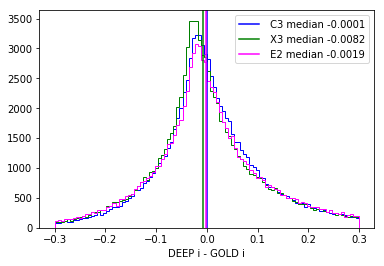

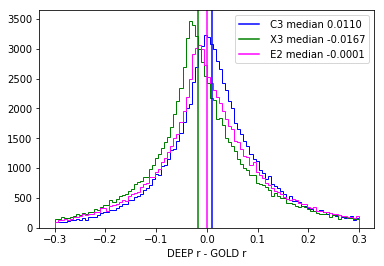

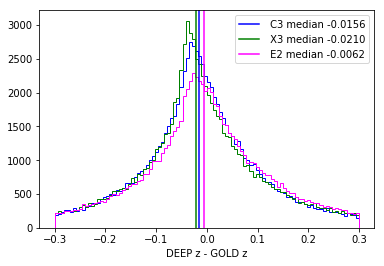

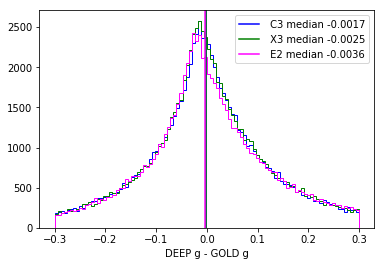

In [20]:
#want a histogram of magnitudes in the matched sample and overall gold and overall deep


#gold deep
#g 01
#r 23
#i 45
#z 67

#CUTS ON MGNITUDES
#gold and deep g < 30 
#gold < 22) & (deep < 22)  

c3match=c3match.astype(float)
maglim=30
c3match=c3match[np.where( (c3match[:,0] < maglim) & (c3match[:,1] < maglim) )]  #both deep and wide g
print(np.shape(c3match))
c3match=c3match[np.where( (c3match[:,2] < maglim))] # & (c3match[:,3] < 22) )]  #rwide
c3match=c3match[np.where( c3match[:,3] < maglim)] #rdeep cut   
print(np.shape(c3match))
c3match=c3match[np.where( (c3match[:,4] < 23.5) & (c3match[:,5] < maglim) )]   #both deep and wide i
print("i cut")
print(np.shape(c3match))
c3match=c3match[np.where( (c3match[:,6] < maglim) & (c3match[:,7] < maglim) )]  #both deep and wide z
print(np.shape(c3match))
c3match=c3match[np.where( (c3match[:,0] >0 ) & (c3match[:,2] >0)  & (c3match[:,4] >0) )]  #all gold >0

x3match=x3match.astype(float)
maglim=30
x3match=x3match[np.where( (x3match[:,0] < maglim) & (x3match[:,1] < maglim) )]  #both deep and wide g
print(np.shape(x3match))
x3match=x3match[np.where( (x3match[:,2] < maglim))] # & (x3match[:,3] < 22) )]  #rwide
x3match=x3match[np.where( x3match[:,3] < maglim)] #rdeep cut   
print(np.shape(x3match))
x3match=x3match[np.where( (x3match[:,4] < 23.5) & (x3match[:,5] < maglim) )]   #both deep and wide i
print(np.shape(x3match))
x3match=x3match[np.where( (x3match[:,6] < maglim) & (x3match[:,7] < maglim) )]  #both deep and wide z
print(np.shape(x3match))
x3match=x3match[np.where( (x3match[:,0] >0 ) & (x3match[:,2] >0)  & (x3match[:,4] >0) )]  #all gold >0


e2match=e2match.astype(float)
maglim=30
e2match=e2match[np.where( (e2match[:,0] < maglim) & (e2match[:,1] < maglim) )]  #both deep and wide g
print(np.shape(e2match))
e2match=e2match[np.where( (e2match[:,2] < maglim))] # & (e2match[:,3] < 22) )]  #rwide
e2match=e2match[np.where( e2match[:,3] < maglim)] #rdeep cut   
print(np.shape(e2match))
e2match=e2match[np.where( (e2match[:,4] < 23.5) & (e2match[:,5] < maglim) )]   #both deep and wide i
print(np.shape(e2match))
e2match=e2match[np.where( (e2match[:,6] < maglim) & (e2match[:,7] < maglim) )]  #both deep and wide z
print(np.shape(e2match))
e2match=e2match[np.where( (e2match[:,0] >0 ) & (e2match[:,2] >0)  & (e2match[:,4] >0) )]  #all gold >0
"""
#CUTS ON MAGNITUDE SUMS
#GB: take the median mag difference of objects with 0.5*(gold+deep) < 22
#We don’t want selection or noise biases to bias the measurement of this offset, so we want to restrict to mags where both catalogs are complete.

magsumlim=60
rsum=  match[:,2]+match[:,3]
print(rsum)
match=match[np.where(rsum < magsumlim)]
rsum=rsum[np.where(rsum < magsumlim)]
print(rsum)
print(np.shape(match))
print(match[:,8])
print("***")
print(match[:,9])

gsum=  match[:,0]+match[:,1]
match=match[np.where(gsum < magsumlim)]
print(np.shape(match))

isum=  match[:,4]+match[:,5]
match=match[np.where(isum < magsumlim)]
print(np.shape(match))

zsum=  match[:,6]+match[:,7]
match=match[np.where(zsum < magsumlim)]
print(np.shape(match))
"""

goldiselect=c3match[:,4].astype(float)
deepiselect=c3match[:,5].astype(float)
goldgselect=c3match[:,0].astype(float)
deepgselect=c3match[:,1].astype(float)
goldrselect=c3match[:,2].astype(float)
deeprselect=c3match[:,3].astype(float)
goldzselect=c3match[:,6].astype(float)
deepzselect=c3match[:,7].astype(float)

print(len(deeprselect),len(goldrselect))
print(deeprselect,goldrselect)
print(deeprselect-goldrselect)
print(c3match[:,10])

print("delta i min max: ", min(deepiselect-goldiselect),max(deepiselect-goldiselect))
print("delta r min max: ", min(deeprselect-goldrselect),max(deeprselect-goldrselect))
fig, ax = plt.subplots()
plt.hist(c3match[:,5].astype(float)-c3match[:,4].astype(float), 100, range=(-0.3, 0.3),histtype='step',color='blue')  #,s=s
plt.hist(x3match[:,5].astype(float)-x3match[:,4].astype(float), 100, range=(-0.3, 0.3),histtype='step',color='green') 
plt.hist(e2match[:,5].astype(float)-e2match[:,4].astype(float), 100, range=(-0.3, 0.3),histtype='step',color='magenta') 
#plt.axvline(x=np.mean(deepiselect-goldiselect), color='red',label=("mean %.4f" %np.mean(deepiselect-goldiselect)))
plt.axvline(x=np.median(c3match[:,5].astype(float)-c3match[:,4].astype(float)), color='blue',label=(" C3 median %.4f" %np.median(c3match[:,5].astype(float)-c3match[:,4].astype(float))))
plt.axvline(x=np.median(x3match[:,5].astype(float)-x3match[:,4].astype(float)), color='green',label=(" X3 median %.4f" %np.median(x3match[:,5].astype(float)-x3match[:,4].astype(float))))
plt.axvline(x=np.median(e2match[:,5].astype(float)-e2match[:,4].astype(float)), color='magenta',label=(" E2 median %.4f" %np.median(e2match[:,5].astype(float)-e2match[:,4].astype(float))))
plt.legend()
plt.xlabel('DEEP i - GOLD i')
#plt.yscale('log')
name="Figs/deltai_matched_hist_all.pdf" 
plt.savefig(name, format='pdf', dpi=1200)

fig, ax = plt.subplots()
plt.hist(c3match[:,3].astype(float)-c3match[:,2].astype(float), 100, range=(-0.3, 0.3),histtype='step',color='blue')  #,s=s
plt.hist(x3match[:,3].astype(float)-x3match[:,2].astype(float), 100, range=(-0.3, 0.3),histtype='step',color='green') 
plt.hist(e2match[:,3].astype(float)-e2match[:,2].astype(float), 100, range=(-0.3, 0.3),histtype='step',color='magenta') 
#plt.axvline(x=np.mean(deeprselect-goldrselect), color='red',label=("mean %.4f" %np.mean(deeprselect-goldrselect)))
plt.axvline(x=np.median(c3match[:,3].astype(float)-c3match[:,2].astype(float)), color='blue',label=(" C3 median %.4f" %np.median(c3match[:,3].astype(float)-c3match[:,2].astype(float))))
plt.axvline(x=np.median(x3match[:,3].astype(float)-x3match[:,2].astype(float)), color='green',label=(" X3 median %.4f" %np.median(x3match[:,3].astype(float)-x3match[:,2].astype(float))))
plt.axvline(x=np.median(e2match[:,3].astype(float)-e2match[:,2].astype(float)), color='magenta',label=(" E2 median %.4f" %np.median(e2match[:,3].astype(float)-e2match[:,2].astype(float))))
plt.legend()
#plt.hist(deepi[np.where(d2d.arcsecond < matchlim)], 50, range=(15, 30))
plt.xlabel('DEEP r - GOLD r')
#plt.yscale('log')
name="Figs/deltar_matched_hist_all.pdf" 
plt.savefig(name, format='pdf', dpi=1200)

fig, ax = plt.subplots()
plt.hist(c3match[:,7].astype(float)-c3match[:,6].astype(float), 100, range=(-0.3, 0.3),histtype='step',color='blue')  #,s=s
plt.hist(x3match[:,7].astype(float)-x3match[:,6].astype(float), 100, range=(-0.3, 0.3),histtype='step',color='green') 
plt.hist(e2match[:,7].astype(float)-e2match[:,6].astype(float), 100, range=(-0.3, 0.3),histtype='step',color='magenta') 
#plt.axvline(x=np.mean(deeprselect-goldrselect), color='red',label=("mean %.4f" %np.mean(deeprselect-goldrselect)))
plt.axvline(x=np.median(c3match[:,7].astype(float)-c3match[:,6].astype(float)), color='blue',label=(" C3 median %.4f" %np.median(c3match[:,7].astype(float)-c3match[:,6].astype(float))))
plt.axvline(x=np.median(x3match[:,7].astype(float)-x3match[:,6].astype(float)), color='green',label=(" X3 median %.4f" %np.median(x3match[:,7].astype(float)-x3match[:,6].astype(float))))
plt.axvline(x=np.median(e2match[:,7].astype(float)-e2match[:,6].astype(float)), color='magenta',label=(" E2 median %.4f" %np.median(e2match[:,7].astype(float)-e2match[:,6].astype(float))))
plt.legend()
#plt.hist(deepi[np.where(d2d.arcsecond < matchlim)], 50, range=(15, 30))
plt.xlabel('DEEP z - GOLD z')
#plt.yscale('log')
name="Figs/deltaz_matched_hist_%s.pdf" % (label)
plt.savefig(name, format='pdf', dpi=1200)


fig, ax = plt.subplots()
plt.hist(c3match[:,1].astype(float)-c3match[:,0].astype(float), 100, range=(-0.3, 0.3),histtype='step',color='blue')  #,s=s
plt.hist(x3match[:,1].astype(float)-x3match[:,0].astype(float), 100, range=(-0.3, 0.3),histtype='step',color='green') 
plt.hist(e2match[:,1].astype(float)-e2match[:,0].astype(float), 100, range=(-0.3, 0.3),histtype='step',color='magenta') 
#plt.axvline(x=np.mean(deeprselect-goldrselect), color='red',label=("mean %.4f" %np.mean(deeprselect-goldrselect)))
plt.axvline(x=np.median(c3match[:,1].astype(float)-c3match[:,0].astype(float)), color='blue',label=(" C3 median %.4f" %np.median(c3match[:,1].astype(float)-c3match[:,0].astype(float))))
plt.axvline(x=np.median(x3match[:,1].astype(float)-x3match[:,0].astype(float)), color='green',label=(" X3 median %.4f" %np.median(x3match[:,1].astype(float)-x3match[:,0].astype(float))))
plt.axvline(x=np.median(e2match[:,1].astype(float)-e2match[:,0].astype(float)), color='magenta',label=(" E2 median %.4f" %np.median(e2match[:,1].astype(float)-e2match[:,0].astype(float))))
plt.legend()
#plt.hist(deepi[np.where(d2d.arcsecond < matchlim)], 50, range=(15, 30))
plt.xlabel('DEEP g - GOLD g')
#plt.yscale('log')
name="Figs/deltag_matched_hist_%s.pdf" % (label)
plt.savefig(name, format='pdf', dpi=1200)





In [ ]:

fig, ax = plt.subplots()
hb=ax.hexbin(goldrselect, deeprselect-goldrselect,bins='log' )#, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
plt.xlim(18,28)
#plt.axhline(y=0, color='red')
plt.ylim(-3,3)
plt.xlabel('GOLD r')
plt.ylabel('DEEP r - GOLD r')
#plt.axhline(y=0, color='red')
plt.xlim(15,23)
plt.ylim(-1.5,2.5)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
name="Figs/deltar_v_goldr_%s.pdf" % (label)
plt.savefig(name, format='pdf', dpi=1200)

fig, ax = plt.subplots()
hb=ax.hexbin(goldiselect, deepiselect-goldiselect,bins='log' )#, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
plt.xlim(18,28)
#plt.axhline(y=0, color='red')
plt.ylim(-3,3)
plt.xlabel('GOLD i')
plt.ylabel('DEEP i - GOLD i')
#plt.axhline(y=0, color='red')
plt.xlim(15,23)
plt.ylim(-1.5,2.5)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
name="Figs/deltai_v_goldi_%s.pdf" % (label)
plt.savefig(name, format='pdf', dpi=1200)


fig, ax = plt.subplots()
hb=ax.hexbin(goldzselect, deepzselect-goldzselect,bins='log' )#, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
plt.xlim(18,28)
#plt.axhline(y=0, color='red')
plt.ylim(-3,3)
plt.xlabel('GOLD z')
plt.ylabel('DEEP z - GOLD z')
#plt.axhline(y=0, color='red')
plt.xlim(15,23)
plt.ylim(-1.5,2.5)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
name="Figs/deltar_v_goldz_%s.pdf" % (label)
plt.savefig(name, format='pdf', dpi=1200)

fig, ax = plt.subplots()
hb=ax.hexbin(goldgselect, deepgselect-goldgselect,bins='log' )#, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
plt.xlim(18,28)
#plt.axhline(y=0, color='red')
plt.ylim(-3,3)
plt.xlabel('GOLD g')
plt.ylabel('DEEP g - GOLD g')
#plt.axhline(y=0, color='red')
plt.xlim(15,23)
plt.ylim(-1.5,2.5)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
name="Figs/deltai_v_goldg_%s.pdf" % (label)
plt.savefig(name, format='pdf', dpi=1200)


In [ ]:
'''


fig, ax = plt.subplots()
hb=ax.hexbin(deeprselect-goldrselect, match[:,10], bins='log' )#, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
plt.xlim(-1.5,1.5)
plt.axhline(y=0, color='red')
plt.ylim(min(match[:,10]),max(match[:,10]))
plt.ylabel('bdf_fracdev')
plt.xlabel('DEEP r - GOLD r')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')

fig, ax = plt.subplots()
hb=ax.hexbin(deeprselect, match[:,10], bins='log' )#, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
#plt.xlim(-1.5,1.5)
plt.axhline(y=0, color='red')
plt.ylim(min(match[:,10]),max(match[:,10]))
plt.ylabel('bdf_fracdev')
plt.xlabel('DEEP r \\')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
'''

"""goldg=goldg[idx][np.where(d2d.arcsecond < matchlim)][np.where(rsum < 44)]
goldi=goldi[idx][np.where(d2d.arcsecond < matchlim)][np.where(rsum < 44)]
goldz=goldz[idx][np.where(d2d.arcsecond < matchlim)][np.where(rsum < 44)]
print(len(goldr[idx][np.where(d2d.arcsecond < matchlim)]))
print(len(goldrselect))
print(rsum)

#usum=  goldu[idx][np.where(d2d.arcsecond < matchlim)] + deepu[np.where(d2d.arcsecond < matchlim)] 
#golduselect=goldu[idx][np.where(d2d.arcsecond < matchlim)][np.where(usum < 44)]
print(len(goldg))
gsum=  goldg[idx][np.where(d2d.arcsecond < matchlim)] + deepg[np.where(d2d.arcsecond < matchlim)] 
goldgselect=goldg[idx][np.where(d2d.arcsecond < matchlim)][np.where(gsum < 44)]
goldi=goldi[idx][np.where(d2d.arcsecond < matchlim)][np.where(gsum < 44)]
goldz=goldz[idx][np.where(d2d.arcsecond < matchlim)][np.where(gsum < 44)]
goldrselect=goldrselect[np.where(gsum < 44)]
print(len(goldgselect))

isum=  goldi[idx][np.where(d2d.arcsecond < matchlim)] + deepi[np.where(d2d.arcsecond < matchlim)] 
goldiselect=goldi[idx][np.where(d2d.arcsecond < matchlim)][np.where(isum < 44)]
print(len(goldiselect))

zsum=  goldz[idx][np.where(d2d.arcsecond < matchlim)] + deepz[np.where(d2d.arcsecond < matchlim)] 
goldzselect=goldz[idx][np.where(d2d.arcsecond < matchlim)][np.where(zsum < 44)]
print(len(goldzselect))"""

In [ ]:
#FOR UVISTA
'''
matchlim=1

flags=gold['FLAGS'][idx][np.where(d2d.arcsecond < matchlim)]
print(flags)

match=np.column_stack((goldi[idx][np.where(d2d.arcsecond < matchlim)], deepi[np.where(d2d.arcsecond < matchlim)], 
                       goldr[idx][np.where(d2d.arcsecond < matchlim)], deepr[np.where(d2d.arcsecond < matchlim)], 
                       goldra[idx][np.where(d2d.arcsecond < matchlim)], deepra[np.where(d2d.arcsecond < matchlim)],
                       golddec[idx][np.where(d2d.arcsecond < matchlim)], deepdec[np.where(d2d.arcsecond < matchlim)],                       
                       deep['bdf_fracdev'][np.where(d2d.arcsecond < matchlim)]))


print("percentage matched: ", float(len(deepi[np.where(d2d.arcsecond < matchlim)]))/float(len(deepi))*100.)
print("num matches before cuts: ", np.shape(match))

#plt.scatter(match[:,3] ,match[:,5] ,color='blue')
#plt.scatter(match[:,2] ,match[:,4] , color='red', s=1)


#want a histogram of magnitudes in the matched sample and overall gold and overall deep

#fig, ax = plt.subplots()
#plt.hist(match[:,1], 50, range=(0, 20)) #20 is the max matching range in arcmin
#plt.xlabel('d2d (arcsec)')


#gold deep
#g 01
#r 23
#i 45
#z 67

#CUTS ON MGNITUDES
#gold < 22) & (deep < 22)  
match=match[np.where(flags==0)]
print("after flags cut: ", np.shape(match))
maglim=30
match=match[np.where( (match[:,0] < maglim) & (match[:,1] < maglim) )]
print("after i- maglim cut: ",np.shape(match))
match=match[np.where( (match[:,2] < maglim) & (match[:,3] < maglim) )]
print("after r- maglim cut: ",np.shape(match))

"""
#CUTS ON MAGNITUDE SUMS
#GB: take the median mag difference of objects with 0.3*(gold+deep) < 22
#We don’t want selection or noise biases to bias the measurement of this offset, so we want to restrict to mags where both catalogs are complete.

magsumlim=60
rsum=  match[:,2]+match[:,3]
print(rsum)
match=match[np.where(rsum < magsumlim)]
rsum=rsum[np.where(rsum < magsumlim)]
print(rsum)
print(np.shape(match))
print(match[:,8])
print("***")
print(match[:,9])

gsum=  match[:,0]+match[:,1]
match=match[np.where(gsum < magsumlim)]
print(np.shape(match))

isum=  match[:,4]+match[:,5]
match=match[np.where(isum < magsumlim)]
print(np.shape(match))

zsum=  match[:,6]+match[:,7]
match=match[np.where(zsum < magsumlim)]
print(np.shape(match))
"""

goldiselect=match[:,0]
deepiselect=match[:,1]
goldrselect=match[:,2]
deeprselect=match[:,3]
#goldrselect=match[:,2]
#deeprselect=match[:,3]
print(max(goldiselect))
print(max(deepiselect))
#plt.hist(deepiselect,50,label="deep",range=(0,30),color="blue",alpha=0.5)
#plt.hist(goldiselect,50,label="gold",range=(0,30),color="red",alpha=0.5)
#plt.legend()

fig, ax = plt.subplots()
hb=ax.hexbin(deepiselect,goldiselect,bins='log')
plt.ylabel('GOLD i')
plt.xlabel('DEEP i')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
plt.xlim(18,28)
plt.ylim(18,28)

fig, ax = plt.subplots()
hb=ax.hexbin(deeprselect,goldrselect,bins='log')
plt.ylabel('GOLD r')
plt.xlabel('DEEP r')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
plt.xlim(18,28)
plt.ylim(18,28)

'''

In [ ]:
#plot magnitudes
#print(len(goldr[idx][np.where(d2d.arcsecond < matchlim)]))
#print(len(deep['bdf_mag'][np.where(d2d.arcsecond < matchlim)]))


#fit = np.polyfit(goldr[idx][np.where(d2d.arcsecond < matchlim)], deepr[np.where(d2d.arcsecond < matchlim)], 1)
#fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y
print(len(deepr))
print(len(deepr[deepr>0]))
#plt.plot(goldr[idx][np.where(d2d.arcsecond < matchlim)], fit_fn(goldr[idx][np.where(d2d.arcsecond < matchlim)]), '--k')
#x = np.linspace(14, 40, 1000)
#plt.plot(x,x,color='red')

print(len(goldrselect))
print("***")
print(len(deeprselect))

toobig=goldrselect<0
print(len(goldrselect[toobig]))


fig, ax = plt.subplots()
hb=ax.hexbin(goldrselect, deeprselect-goldrselect,bins='log' )#, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
plt.xlim(18,28)
#plt.axhline(y=0, color='red')
plt.ylim(-3,3)
plt.xlabel('GOLD r')
plt.ylabel('DEEP r - GOLD r')
plt.axhline(y=0, color='red')
plt.xlim(15,23)
plt.ylim(-1.5,2.5)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
name="Figs/deltar_v_goldr_%s.pdf" % (label)
plt.savefig(name, format='pdf', dpi=1200)

fig, ax = plt.subplots()
hb=ax.hexbin(goldiselect, deepiselect-goldiselect,bins='log' )#, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
plt.xlim(18,28)
#plt.axhline(y=0, color='red')
plt.ylim(-3,3)
plt.xlabel('GOLD i')
plt.ylabel('DEEP i - GOLD i')
plt.axhline(y=0, color='red')
plt.xlim(15,23)
plt.ylim(-1.5,2.5)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
name="Figs/deltai_v_goldi_%s.pdf" % (label)
plt.savefig(name, format='pdf', dpi=1200)


In [ ]:
fig, ax = plt.subplots()
plt.hist(deeprselect-goldrselect, 50, range=(-0.4, 0.4))  #,s=s
plt.axvline(x=np.mean(deeprselect-goldrselect), color='red',label=("mean"))
plt.axvline(x=np.median(deeprselect-goldrselect), color='black',label=("median"))
plt.legend()
print("median deltai",np.median(deeprselect-goldrselect))
print("mean deltai",np.mean(deeprselect-goldrselect))
#plt.hist(deepi[np.where(d2d.arcsecond < matchlim)], 50, range=(15, 30))
plt.xlabel('delta r')
#plt.yscale('log')

name="Figs/deltar_matched_hist_%s.pdf" % (label)
plt.savefig(name, format='pdf', dpi=1200)



fig, ax = plt.subplots()
plt.hist(deepiselect-goldiselect, 50, range=(-0.4, 0.4))  #,s=s
plt.axvline(x=np.mean(deepiselect-goldiselect), color='red',label=("mean"))
plt.axvline(x=np.median(deepiselect-goldiselect), color='black',label=("median"))
plt.legend()
print("median deltar",np.median(deepiselect-goldiselect))
print("mean deltar",np.mean(deepiselect-goldiselect))
#plt.hist(deepi[np.where(d2d.arcsecond < matchlim)], 50, range=(15, 30))
plt.xlabel('delta i')
#plt.yscale('log')

name="Figs/deltai_matched_hist_%s.pdf" % (label)
plt.savefig(name, format='pdf', dpi=1200)



In [ ]:
print(np.shape(match))
#pull out r-off peak
keep=match[np.where((deeprselect-goldrselect)<-0.05),:][0]
keepi=match[np.where((deepiselect-goldiselect)<-0.05),:][0]
print(np.shape(keep))
print(keep[:,3]-keep[:,2])

#check I pulled it out right
plt.hist((keep[:,3]-keep[:,2]), 50, range=(-0.4, 0.4))
plt.axvline(x=0, color='red')
plt.axvline(x=np.median(keep[:,3]-keep[:,2]), color='black')
print(np.median(keep[:,3]-keep[:,2]))
print(np.mean(keep[:,3]-keep[:,2]))
#plt.hist(deepi[np.where(d2d.arcsecond < matchlim)], 50, range=(15, 30))
plt.xlabel('deepr-goldr for only the r- off-peak')

In [ ]:
#Do the two subsets have the same gold r mag distributions?
#Gold r-mag compared to deep of pulled out
plt.hist(keep[:,2],50,label="gold",color="blue",alpha=0.5)
plt.hist(keep[:,3],50,label="deep",color="red",alpha=0.5)
plt.xlabel('r-mags for rpulled out')
plt.legend()



In [ ]:
plt.hist(keep[:,5],50,label="deep",color="red",alpha=0.5)
plt.hist(keep[:,4],50,label="gold",color="blue",alpha=0.5)
plt.xlabel('i-mags for rpulled out')
plt.legend()


fig = plt.figure()
plt.hist(keep[:,5]-keep[:,4], 50,range=(-0.5,0.5))
plt.xlabel('delta i- for the only the r- off peak')


#Are the two subsets spatially distinct in any way?
fig, ax = plt.subplots()
hb=ax.hexbin(keep[:,9], keep[:,11],bins='log' )#, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
plt.xlabel('deep RA - roffpeak')
plt.ylabel('deep Dec')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
name="Figs/deltaroutliers_radec_%s.pdf" % (label)
plt.savefig(name, format='pdf', dpi=1200)

fig = plt.figure()
plt.hist(keepi[:,5]-keepi[:,4], 50,range=(-0.5,0.5))
plt.xlabel('delta i- for the only the i- off peak')


#Are the two subsets spatially distinct in any way?
fig, ax = plt.subplots()
hb=ax.hexbin(keepi[:,9], keepi[:,11],bins='log' )#, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
plt.xlabel('deep RA -i offpeak')
plt.ylabel('deep Dec')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
name="Figs/deltaioutliers_radec_%s.pdf" % (label)
plt.savefig(name, format='pdf', dpi=1200)

#Are the distributions of fracdev the same between these two subsets?
fig, ax = plt.subplots()
hb=ax.hexbin(keep[:,3]-keep[:,2], keep[:,10], bins='log' )#, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
plt.xlim(-1.5,1.5)
plt.axhline(y=0, color='red')
plt.ylim(min(match[:,10]),max(match[:,10]))
plt.ylabel('bdf_fracdev')
plt.xlabel('DEEP r - GOLD r')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')

fig, ax = plt.subplots()
plt.hist(match[:,10], 50, color='blue')
#plt.hist(keep[:,10], 50,color='red')
plt.xlabel('bdf_fracdev')

fig, ax = plt.subplots()
hb=ax.hexbin(keep[:,3]-keep[:,2], keep[:,10], bins='log' )#, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
#plt.xlim(-1.5,1.5)
plt.axhline(y=0, color='red')
plt.ylim(min(match[:,10]),max(match[:,10]))
plt.ylabel('bdf_fracdev')
plt.xlabel('DEEP r -GOLD r')

cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')

fig, ax = plt.subplots()
hb=ax.hexbin(keep[:,1]-keep[:,3],keep[:,3]-keep[:,5] ,bins='log')#, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
#plt.scatter(deepgselect-deeprselect,deeprselect-deepiselect,marker='.', facecolors='blue', color='blue',alpha=0.2)
plt.xlabel('g-r')
plt.ylabel('r-i')
#plt.xlim(-1.5,3)
#plt.ylim(-1.5,3)
plt.xlim(0,2)
plt.ylim(-0.5,2.0)
name="Figs/r-i_v_g-r_matched_%s.pdf" % (label)
plt.savefig(name, format='pdf', dpi=1200)

In [ ]:
#plot magnitudes

#fit = np.polyfit(goldr[idx][np.where(d2d.arcsecond < matchlim)], deepr[np.where(d2d.arcsecond < matchlim)], 1)
#fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y
#plt.plot(goldr[idx][np.where(d2d.arcsecond < matchlim)], fit_fn(goldr[idx][np.where(d2d.arcsecond < matchlim)]), '--k')
#x = np.linspace(14, 40, 1000)
#plt.plot(x,x,color='red')

fig, ax = plt.subplots()
hb=ax.hexbin(goldiselect, deepiselect-goldiselect, bins='log')#, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
#plt.scatter(goldiselect, deepiselect-goldiselect, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
plt.axhline(y=0, color='red')
plt.xlim(15,23)
plt.ylim(-1.5,2.5)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log(N)')

plt.xlabel('GOLD i')
plt.ylabel('DEEP i - GOLD i')
name="Figs/deltai_v_goldi_%s.pdf" % (label)
plt.savefig(name, format='pdf', dpi=1200)

In [ ]:
plt.hist(deepiselect-goldiselect, 50) #, range=(-0.4, 0.4))
plt.axvline(x=np.mean(deepiselect-goldiselect), color='red',label=("mean"))
plt.axvline(x=np.median(deepiselect-goldiselect), color='black',label=("median"))
plt.legend()
plt.xlim(-5,2)
print("median",np.median(deepiselect-goldiselect))
print("mean",np.mean(deepiselect-goldiselect))
#plt.hist(deepi[np.where(d2d.arcsecond < matchlim)], 50, range=(15, 30))
plt.xlabel('delta i')
name="Figs/deltai_matched_hist_%s.pdf" % (label)
plt.savefig(name, format='pdf', dpi=1200)




In [ ]:
plt.hist(deeprselect-goldrselect, 50, range=(-0.4, 0.4))
plt.axvline(x=0, color='black')
print(np.median(deeprselect-goldrselect))
print(np.mean(deeprselect-goldrselect))
plt.axvline(x=np.median(deeprselect-goldrselect), color='red')
#plt.hist(deepi[np.where(d2d.arcsecond < matchlim)], 50, range=(15, 30))
plt.xlabel('delta r')
name="Figs/deltar_matched_hist_%s.pdf" % (label)
plt.savefig(name, format='pdf', dpi=1200)

### colour-colour
plt.scatter(deeprselect-deepiselect,deepgselect-deeprselect, marker='.') #,markersize=10 )
plt.xlabel('r-i')
plt.ylabel('g-r')

In [ ]:
fig, ax = plt.subplots()
hb=ax.hexbin(deepgselect-deeprselect,deeprselect-deepiselect ,bins='log')#, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
#plt.scatter(deepgselect-deeprselect,deeprselect-deepiselect,marker='.', facecolors='blue', color='blue',alpha=0.2)
plt.xlabel('g-r')
plt.ylabel('r-i')
#plt.xlim(-1.5,3)
#plt.ylim(-1.5,3)
plt.xlim(0,2)
plt.ylim(-0.5,2.0)
name="Figs/r-i_v_g-r_matched_%s.pdf" % (label)
plt.savefig(name, format='pdf', dpi=1200)